#En este cuaderno vamos a realizar la extraccion y limpieza de datos del TFM de energia nuclear


Dado que como todo en este mundo depende de infindad de variables, y no podemos tenerlas en cuenta todas, nos vamos a centrar en lo siguiente,a ver que te parece

Datos del coste de energia y produccion energetica
     Precios historicos, gastos de generacion, produccion energetica total, factores de capacidad

Costo de implementacion y mantenimiento
     construccion de nuevas plantas, operacion y mantenimiento, desmantelamiento, trata de residuos nucleares

### Historicos energéticos

En este apartado sacaremos datos historicos de varias variables, el precio historico del kwh, el precio historico de los gastos de generacion, la produccion energetica total, y factores de capacidad total, de las dos principales fuentes de energia, que son la electrica y gas natural, y la energia nuclear


Datos que sí deberías obtener por fuente:

Costo de generación histórico por kWh (LCOE).

Producción energética total por fuente (nuclear, gas natural, renovables).

Factores de capacidad por fuente (cuánta energía genera realmente una planta respecto a su capacidad máxima).

El LCOE (Levelized Cost of Energy), o Costo Nivelado de Energía, es una métrica que se utiliza para calcular el costo total de producción de electricidad por unidad de energía (normalmente expresada en USD/MWh o €/MWh) durante toda la vida útil de una planta energética.



The US has the largest nuclear power plant fleet with 104 GW in 2018, followed by France (63 GW), China (45 GW), Japan (37 GW) and Russia (29 GW).
Por tanto un estudio basado en estados unidos seria optimo

Exctraemos los datos de energia nuclear del siguiente enlace

https://www.eia.gov/nuclear/data.php#nuclear

De aqui sacamos el Table8.1 energy overview


De aqui sacamos el dataset power plants database global

https://www.kaggle.com/datasets/alistairking/nuclear-energy-datasets

In [ ]:
#Insalamos las librerias para la api de open-meteo

!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install ydata-profiling
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.5/393.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=77b0334d5c5c572bb007572c6a30e4bcfda2350bfc652a830296ac78d8b7cd54
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import importlib.util
import subprocess

# Lista de paquetes que queremos instalar si no están presentes
packages = [
    "openmeteo-requests",
    "requests-cache",
    "retry-requests",
    "numpy",
    "pandas",
    "ydata-profiling",
    "skforecast"
]

# Función para verificar e instalar paquetes
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Instalando {package}...")
        subprocess.check_call(["pip", "install", package])
    else:
        print(f"{package} ya está instalado.")

# Iterar sobre la lista de paquetes
for package in packages:
    install_if_missing(package)

Instalando openmeteo-requests...
Instalando requests-cache...
Instalando retry-requests...
numpy ya está instalado.
pandas ya está instalado.
Instalando ydata-profiling...
skforecast ya está instalado.


In [ ]:
#Importamos las librerias básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
import matplotlib.dates as mdates


In [ ]:
# Cargar el archivo Excel
file_path = '/content/Table_8.1_Nuclear_Energy_Overview.xlsx'
excel_data = pd.ExcelFile(file_path)

# Listar los nombres de las hojas para identificar su contenido
sheet_names = excel_data.sheet_names
sheet_names

# Cargar las hojas de datos para inspeccionar su contenido
monthly_data = excel_data.parse('Monthly Data')
annual_data = excel_data.parse('Annual Data')

# Mostrar las primeras filas de cada hoja
monthly_data.head(), annual_data.head()

# Buscar las primeras filas con datos válidos
monthly_data_clean = monthly_data.dropna(how='all').reset_index(drop=True)
annual_data_clean = annual_data.dropna(how='all').reset_index(drop=True)

# Mostrar las primeras filas después de limpiar las filas vacías
monthly_data_clean.head(10), annual_data_clean.head(10)

# Definir los encabezados de las columnas
column_headers = [
    "Date",
    "Total_Operable_Units",
    "Net_Summer_Capacity_MW",
    "Net_Generation_MWh",
    "Share_of_Electricity_Percent",
    "Capacity_Factor_Percent"
]

# Extraer datos válidos de las tablas
monthly_data_extracted = monthly_data_clean.iloc[7:].reset_index(drop=True)
monthly_data_extracted.columns = column_headers

annual_data_extracted = annual_data_clean.iloc[7:].reset_index(drop=True)
annual_data_extracted.columns = column_headers

# Convertir las fechas a formato datetime donde sea posible
monthly_data_extracted['Date'] = pd.to_datetime(monthly_data_extracted['Date'], errors='coerce')
annual_data_extracted['Date'] = pd.to_datetime(annual_data_extracted['Date'], errors='coerce', format='%Y')

# Convertir las columnas numéricas
numeric_columns = column_headers[1:]
for col in numeric_columns:
    monthly_data_extracted[col] = pd.to_numeric(monthly_data_extracted[col], errors='coerce')
    annual_data_extracted[col] = pd.to_numeric(annual_data_extracted[col], errors='coerce')

# Mostrar las tablas al usuario
monthly_data_extracted, annual_data_extracted

monthly_data_extracted.set_index('Date', inplace=True)
annual_data_extracted.set_index('Date', inplace=True)

In [ ]:
monthly_data_extracted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 623 entries, 1973-01-01 to 2024-11-01
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Total_Operable_Units          381 non-null    float64
 1   Net_Summer_Capacity_MW        623 non-null    float64
 2   Net_Generation_MWh            623 non-null    int64  
 3   Share_of_Electricity_Percent  623 non-null    float64
 4   Capacity_Factor_Percent       623 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 29.2 KB


In [ ]:
monthly_data_extracted.describe().round(2)

Total_Operable_Units  Net_Summer_Capacity_MW  Net_Generation_MWh  \
count                381.00                  623.00              623.00   
mean                 100.72                   85.77            50012.00   
std                    7.85                   23.15            19585.09   
min                   42.00                   14.53             5697.00   
25%                   99.00                   80.00            33108.00   
50%                  104.00                   98.16            57509.00   
75%                  104.00                   99.63            65202.00   
max                  112.00                  102.21            74649.00   

       Share_of_Electricity_Percent  Capacity_Factor_Percent  
count                        623.00                   623.00  
mean                          17.23                    76.72  
std                            4.15                    16.28  
min                            3.90                    34.60  
25%                           15.80                    61.25  
50%                           18.80                    79.50  
75%                           20.10                    92.10  
max                           22.90                   101.60

In [ ]:
#Vemos cuantos daots NAN tenemos
num_nan_rows_monthly = monthly_data_extracted['Total_Operable_Units'].isna().sum()
num_nan_rows_annual = annual_data_extracted['Total_Operable_Units'].isna().sum()

print(f"Filas con NaN en monthly_data_extracted: {num_nan_rows_monthly}")
print(f"Filas con NaN en annual_data_extracted: {num_nan_rows_annual}")

#Vemos que fechas tienen NaN
nan_indices = monthly_data_extracted[monthly_data_extracted.isna().any(axis=1)].index
print(nan_indices)

#vemos si hay nan despues de 1994 11 01 (No hay)
has_nans = monthly_data_extracted.loc['1994-12-01':].isna().any().any()
print(has_nans)

nan_rows_count = monthly_data_extracted.loc[:'1994-11-01'].isna().any(axis=1).sum()
no_nan_rows_count = (~monthly_data_extracted.loc[:'1994-11-01'].isna().any(axis=1)).sum()
print(f"Filas con NaN hasta 1994-11-01: {nan_rows_count}, Filas sin NaN hasta 1994-11-01: {no_nan_rows_count}")

Filas con NaN en monthly_data_extracted: 242
Filas con NaN en annual_data_extracted: 0
DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '1994-02-01', '1994-03-01', '1994-04-01', '1994-05-01',
               '1994-06-01', '1994-07-01', '1994-08-01', '1994-09-01',
               '1994-10-01', '1994-11-01'],
              dtype='datetime64[ns]', name='Date', length=242, freq=None)
False
Filas con NaN hasta 1994-11-01: 242, Filas sin NaN hasta 1994-11-01: 21


In [ ]:
#Importamos librerias de plots
from matplotlib import pyplot as plt
from seaborn import heatmap
import matplotlib.dates as mdates

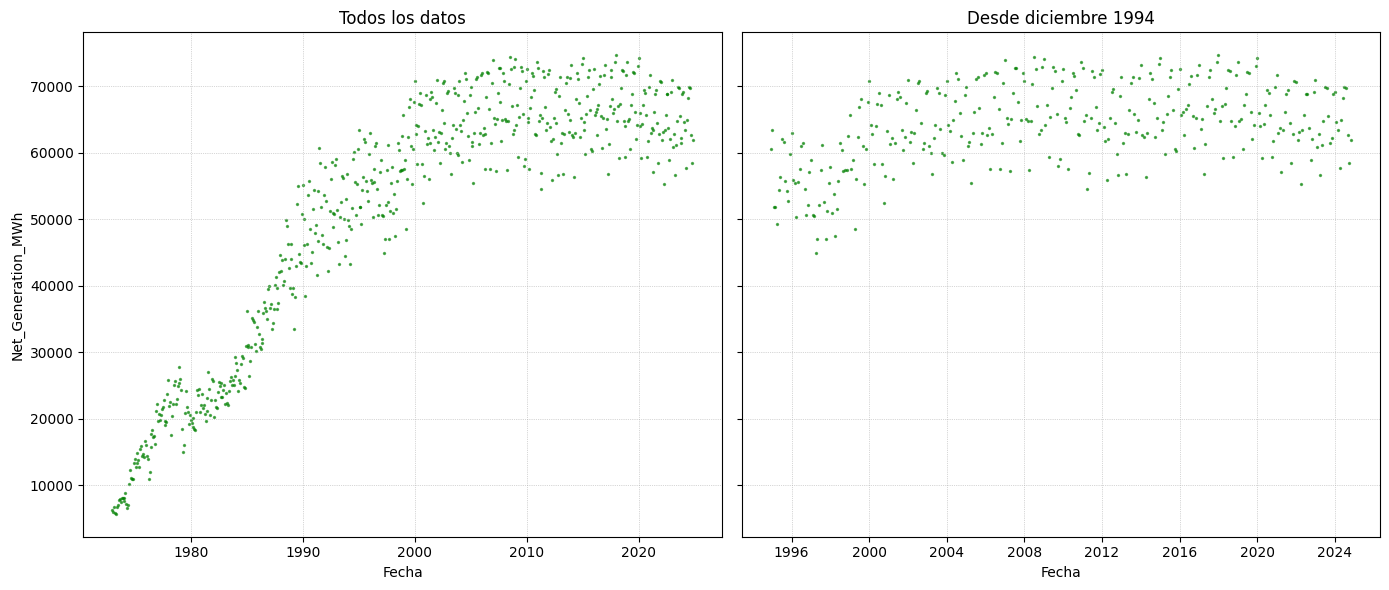

In [ ]:
import matplotlib.pyplot as plt

# Crear figura con dos subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True)  # sharey para compartir el mismo eje Y

# Estilo de puntos
scatter_style = {'color': 'green', 'alpha': 0.6, 's': 2}

# Gráfico 1: Todos los datos
axes[0].scatter(monthly_data_extracted.index, monthly_data_extracted['Net_Generation_MWh'], **scatter_style)
axes[0].set_title('Todos los datos')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Net_Generation_MWh')
axes[0].grid(True, linestyle=':', linewidth=0.5)

# Filtrar datos desde diciembre 1994 en adelante
filtered_data = monthly_data_extracted.loc['1994-12-01':]

# Gráfico 2: Datos desde diciembre 1994
axes[1].scatter(filtered_data.index, filtered_data['Net_Generation_MWh'], **scatter_style)
axes[1].set_title('Desde diciembre 1994')
axes[1].set_xlabel('Fecha')
axes[1].grid(True, linestyle=':', linewidth=0.5)

# Ajustar espacios
plt.tight_layout()
plt.show()


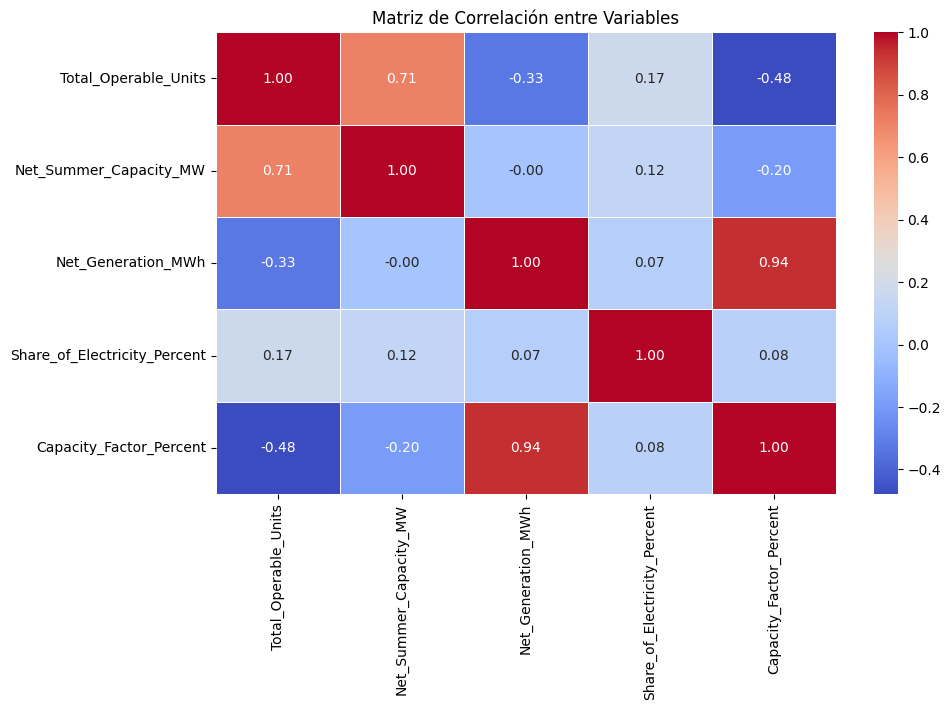

In [ ]:
# Crear un heatmap de correlación
plt.figure(figsize=(10,6))
sns.heatmap(filtered_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()


###¿Por que quitamos las filas NaN?

En nuestro caso, las filas NaN, son la mayoria de los primeros años, para ser concretos, todos los años desde el primer dato, hasta diciembre de 1994, menos 21 meses repartidos en ese periodod e 1973 hasta 1994 tienen NaN en la columna de Operable Unnits, dado que no sabemos cuantas plantas nucleares habia activas, esto nos hace que no sea de confianza el resto de medidas, ya que no sabemos si las plantas son eficientes o no, además, dado que son datos de hace 50-30 años, la tecnología y política era muy distinta, por tanto, la eficiencia de las plantas en la época era muy distinta, y en una gráfica se puede ver que son outliers, por tanto, tiene sentido remover esos datos y no tenerlos en cuenta a la hora realizar análisis y ajustes


In [ ]:
print(monthly_data_extracted.isna().sum())

Total_Operable_Units            242
Net_Summer_Capacity_MW            0
Net_Generation_MWh                0
Share_of_Electricity_Percent      0
Capacity_Factor_Percent           0
dtype: int64


In [ ]:
#Eliminamos las filas NaN de monthly, y los datos antes de 1994, para evitar Nan y outliers
# Guardar las primeras filas (las que contienen NaN) en una copia aparte
old_data_backup = monthly_data_extracted.loc[:'1994-11-01'].copy()

# Dropear las filas antes de diciembre de 1994 en el DataFrame original
monthly_data_extracted = monthly_data_extracted.loc['1994-12-01':]

print(f"Filas con NaN en monthly_data_extracted: {monthly_data_extracted['Total_Operable_Units'].isna().sum()}")
print(f"Filas con NaN en annual_data_extracted: {annual_data_extracted['Total_Operable_Units'].isna().sum()}")
monthly_data_extracted.shape
monthly_data_extracted.head()

Filas con NaN en monthly_data_extracted: 0
Filas con NaN en annual_data_extracted: 0


Total_Operable_Units  Net_Summer_Capacity_MW  Net_Generation_MWh  \
Date                                                                           
1994-12-01                 109.0                  99.148               60497   
1995-01-01                 109.0                  99.148               63342   
1995-02-01                 109.0                  99.148               51858   
1995-03-01                 109.0                  99.148               51880   
1995-04-01                 109.0                  99.148               49321   

            Share_of_Electricity_Percent  Capacity_Factor_Percent  
Date                                                               
1994-12-01                          22.4                     82.0  
1995-01-01                          22.6                     85.9  
1995-02-01                          20.6                     77.8  
1995-03-01                          19.9                     70.3  
1995-04-01                          20.2                     69.2

##Vamos a visualizar las variables para analizar las tendencias de cada una de ellas


In [ ]:
#Importamos librerias de plots
from matplotlib import pyplot as plt
from seaborn import heatmap
import matplotlib.dates as mdates

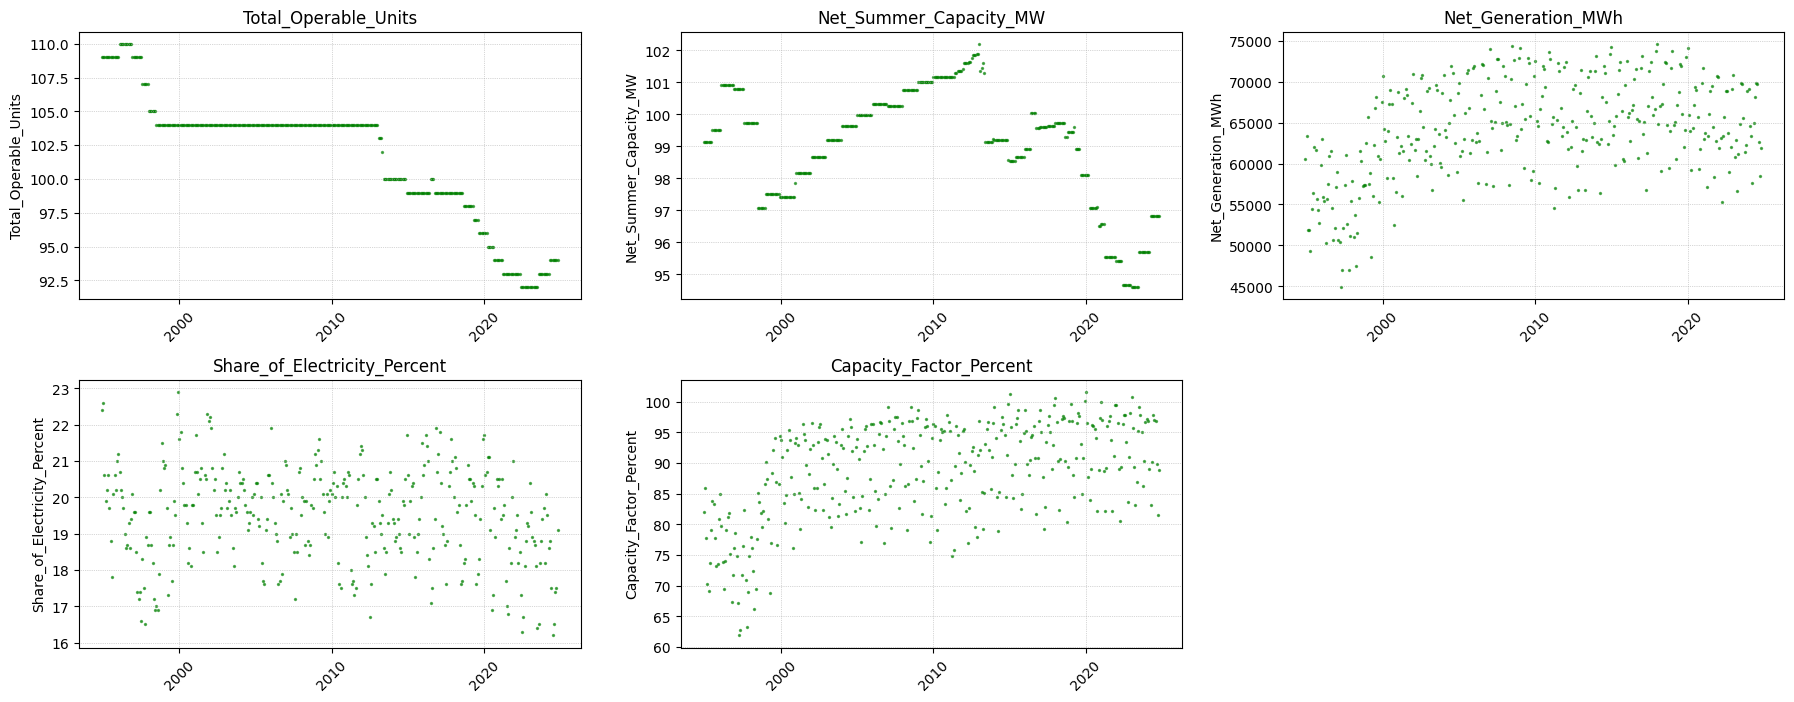

In [ ]:

# Crear figura más grande y con más separación
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 8))
axes = axes.flatten()  # Aplanar los ejes

# Estilo de puntos más limpio
scatter_style = {'color': 'green', 'alpha': 0.6, 's': 2}  # Tamaño de puntos más pequeños

# Graficar cada variable como scatter plot
for i, column in enumerate(monthly_data_extracted.columns):
    axes[i].scatter(monthly_data_extracted.index, monthly_data_extracted[column], **scatter_style)
    axes[i].set_ylabel(column)
    axes[i].grid(True, linestyle=':', linewidth=0.5)  # Cuadrícula más sutil
    axes[i].set_title(f"{column}", fontsize=12)  # Títulos más pequeños

    # Fechas más espaciadas
    axes[i].xaxis.set_major_locator(mdates.YearLocator(10))  # Etiqueta cada 10 años
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)

# Eliminar el último gráfico vacío (posición 5)
fig.delaxes(axes[len(monthly_data_extracted.columns)])

# Ajustar espacios entre gráficos
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()


####significado de cada columna en el contexto de la energía nuclear:

***Total Operable Units:***

Número total de reactores nucleares operativos en EE.UU. durante el período de tiempo correspondiente.
Solo se incluyen los reactores que están en funcionamiento y listos para generar electricidad.


***Capacidad neta en verano de las unidades nucleares*** (Nuclear Generating Units, Net Summer Capacity):

Es la capacidad máxima de generación de electricidad que pueden producir las plantas nucleares en condiciones de calor del verano.
Se mide en megavatios eléctricos (MWe) y representa la potencia máxima sostenida que una central puede suministrar en la red en esas condiciones.


***Generación neta de electricidad de energía nuclear*** (Nuclear Electricity Net Generation):

Es la cantidad total de electricidad generada por plantas nucleares menos la energía que ellas mismas consumen para su operación interna.
Se mide en gigavatios-hora (GWh) y representa la cantidad real de energía que llega a la red eléctrica.


***Participación de la energía nuclear en la generación total de electricidad ***(Nuclear Share of Electricity Net Generation):

Representa el porcentaje de electricidad en EE.UU. que proviene de la energía nuclear.
Se calcula dividiendo la electricidad generada por energía nuclear entre la generación total de electricidad en el país.


***Factor de capacidad de las unidades nucleares*** (Nuclear Generating Units, Capacity Factor):

Es el porcentaje de tiempo que las plantas nucleares operaron a su máxima capacidad teórica.
Se calcula como la energía realmente generada en un período dividido entre la cantidad que se habría producido si el reactor hubiera funcionado al 100% de su capacidad.
Un factor de capacidad alto (por ejemplo, >90%) indica que los reactores han estado operando casi todo el tiempo.



####Caida en la cantidad de plantas operativas

Hay dos periodos claros a partir de los cuales, se produjo una caída en la cantidad de plantas operativas, al rededor de 1990 y 2010.

Estos dos puntos de caída podrían concidir con los dos desastres mas conocidos, el de Chernobyl en 1986 y el de Fukushima en 2011.

Aun que no hay, decretos u órdenes directas sobre el desmantelamiento de plantas tras estos incidentes, es cierto que la opinión pública se vio afectada, y las medidas de seguridad y regulaciones se fortificaron.
Esto provocó que hubiera que modernizar las plantas nucleares, a nivel de infrastructura, de personal y protocolos, y sobre todo en plantas antiguas, hay que tener en cuenta que algunas se construyeron en los años 70, era simplemente mas eficiente a nivel económico desmantelarlas que modernizarlas, e incluso construir plantas nuevas.


##Transformaciones posibles


Dividir métricas por Total_Operable_Units	Comparar eficiencia por planta

Variación interanual (YoY %)	Analizar cambios a largo plazo

Media móvil (12 meses)	Suavizar fluctuaciones mensuales

Diferencias (diff())	Ver cambios abruptos mes a mes

Logaritmo (log1p())	Reducir la variabilidad de los datos



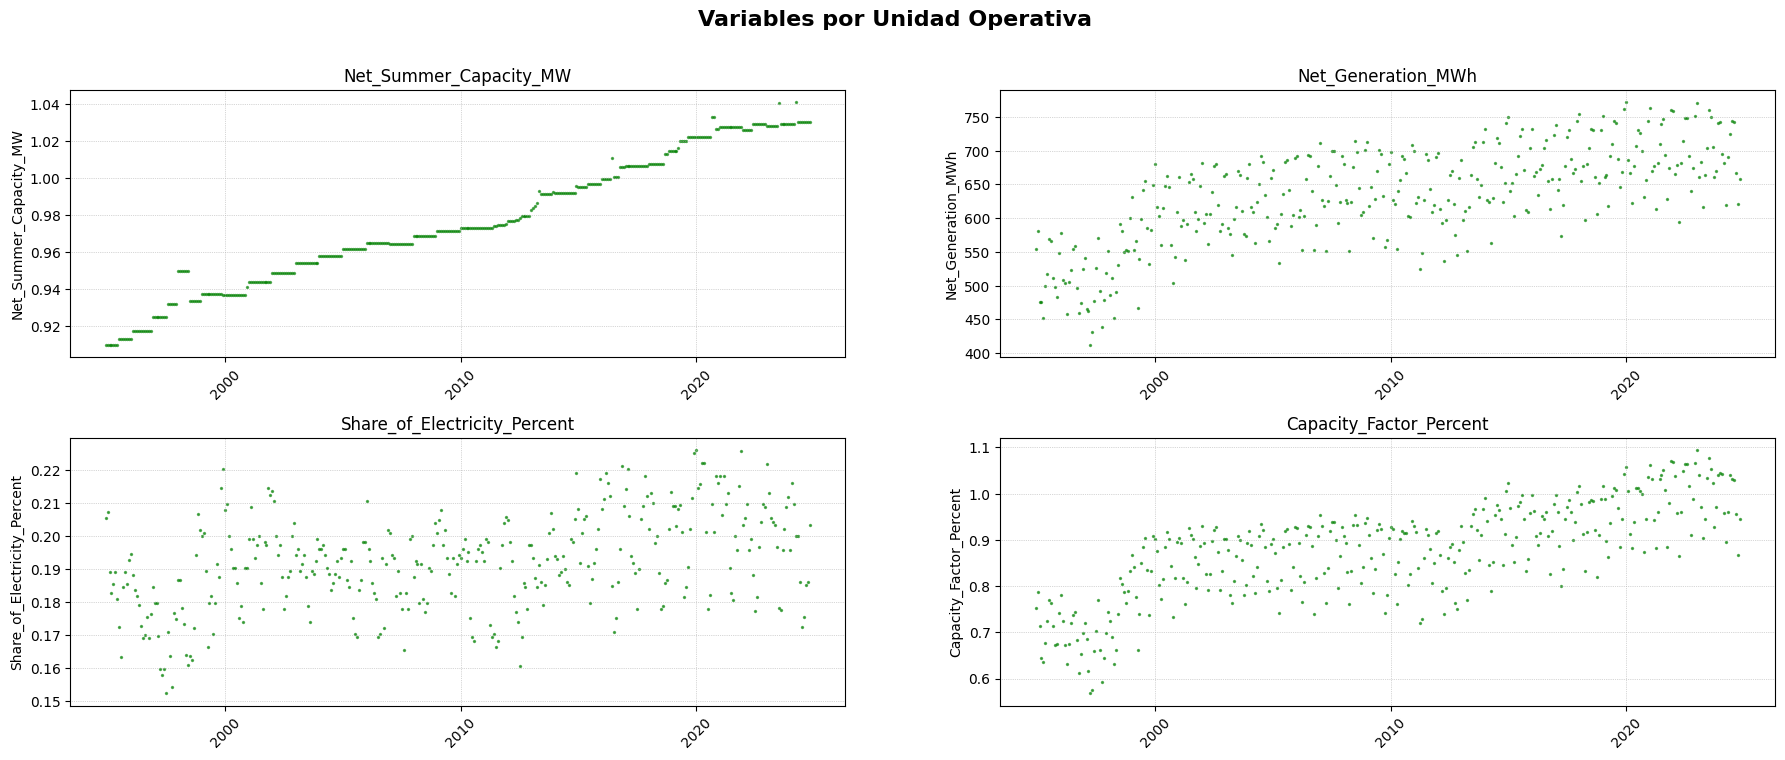

In [ ]:
#Variable por unidad operativa
monthly_data_per_unit = monthly_data_extracted.drop(columns=['Total_Operable_Units']).div(monthly_data_extracted['Total_Operable_Units'], axis=0)


# Crear figura más grande y con más separación
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 8))
axes = axes.flatten()  # Aplanar los ejes

# Estilo de puntos más limpio
scatter_style = {'color': 'green', 'alpha': 0.6, 's': 2}  # Tamaño de puntos más pequeños

# Graficar cada variable como scatter plot
for i, column in enumerate(monthly_data_per_unit.columns):
    axes[i].scatter(monthly_data_per_unit.index, monthly_data_per_unit[column], **scatter_style)
    axes[i].set_ylabel(column)
    axes[i].grid(True, linestyle=':', linewidth=0.5)  # Cuadrícula más sutil
    axes[i].set_title(f"{column}", fontsize=12)  # Títulos más pequeños

    # Fechas más espaciadas
    axes[i].xaxis.set_major_locator(mdates.YearLocator(10))  # Etiqueta cada 10 años
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)


# Título global del gráfico
fig.suptitle("Variables por Unidad Operativa", fontsize=16, fontweight='bold')


# Ajustar espacios entre gráficos
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()


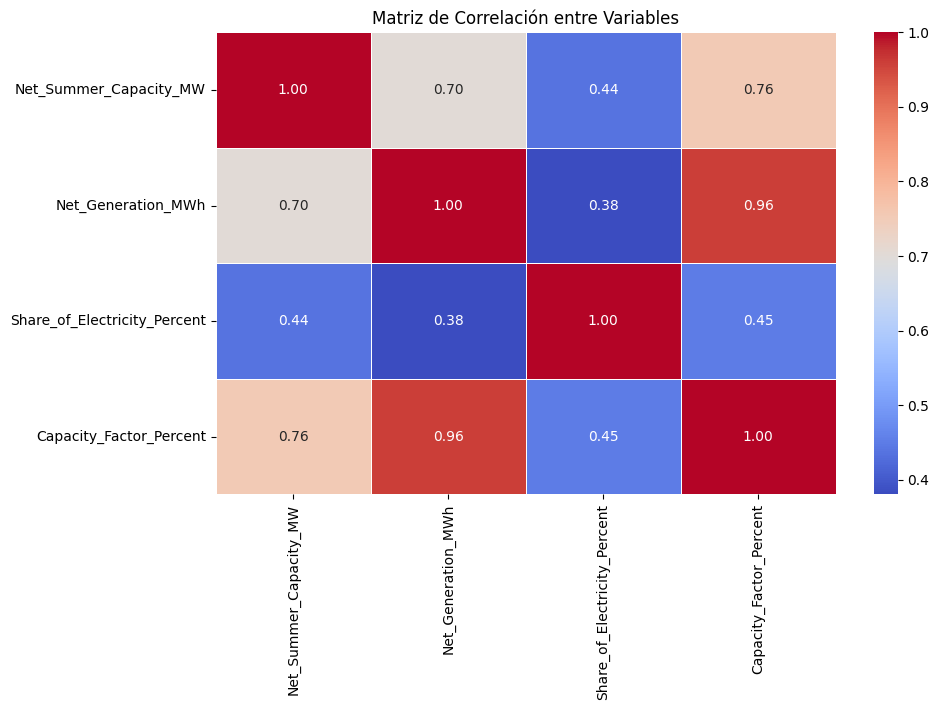

In [ ]:
# Crear un heatmap de correlación
plt.figure(figsize=(10,6))
sns.heatmap(monthly_data_per_unit.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()


###Análisis del gráfico de Variables por Unidad Operativa

A pesar de que en los gráficos generales, no parecia haber un patrón claro de crecimiento ascendente de las variables, al ver como funciona cada variable en función de las plantas nucleares activas en cada momento, podemos ver un crecimiento claramente ascendente, en todas las variables, especialmente en la ***generación neta de energía***, y en la ***capacidad neta en verano***.

Aunque no es constante el crecimiento, si miramos a lo largo de los ultimos 30 años es claramente creciente.

#### Net summer capacity y Net generation

El crecimiento constante indica una mejora continua de tecnología que ha permitido que cada reactor produzca mas energia, y debido a que los reactores operativos han disminuido, indica mas bien una modernizacion y mejora de las propias plantas, que la creacion de nuevas plantas, lo cual seria un proceso reproducible en el futuro

#### Share if Electricity Percent

A pesar de que las plantas nucleares han disminuido en número, el porcentaje de electricidad se ha mantenido incluso crecido un poco, lo que indica la mejora de eficiencia de las plantas, pero también la aparición de nuevas tecnologías como la solar, eólica etc.

#### Capacity Factor Percent

Esto indica que cada vez cada reactor trabaja a mas capacidad durante mas tiempo


###Conclusión

Las plantas nucleares estan mejorando su tecnología, permitiendo generar energía mas eficientemente durante mas tiempo, y se esta realizando un trabajo de modernizacion, mas que de construccion de nuevas plantas



Index(['Net_Summer_Capacity_MW', 'Net_Generation_MWh',
       'Share_of_Electricity_Percent', 'Capacity_Factor_Percent'],
      dtype='object')


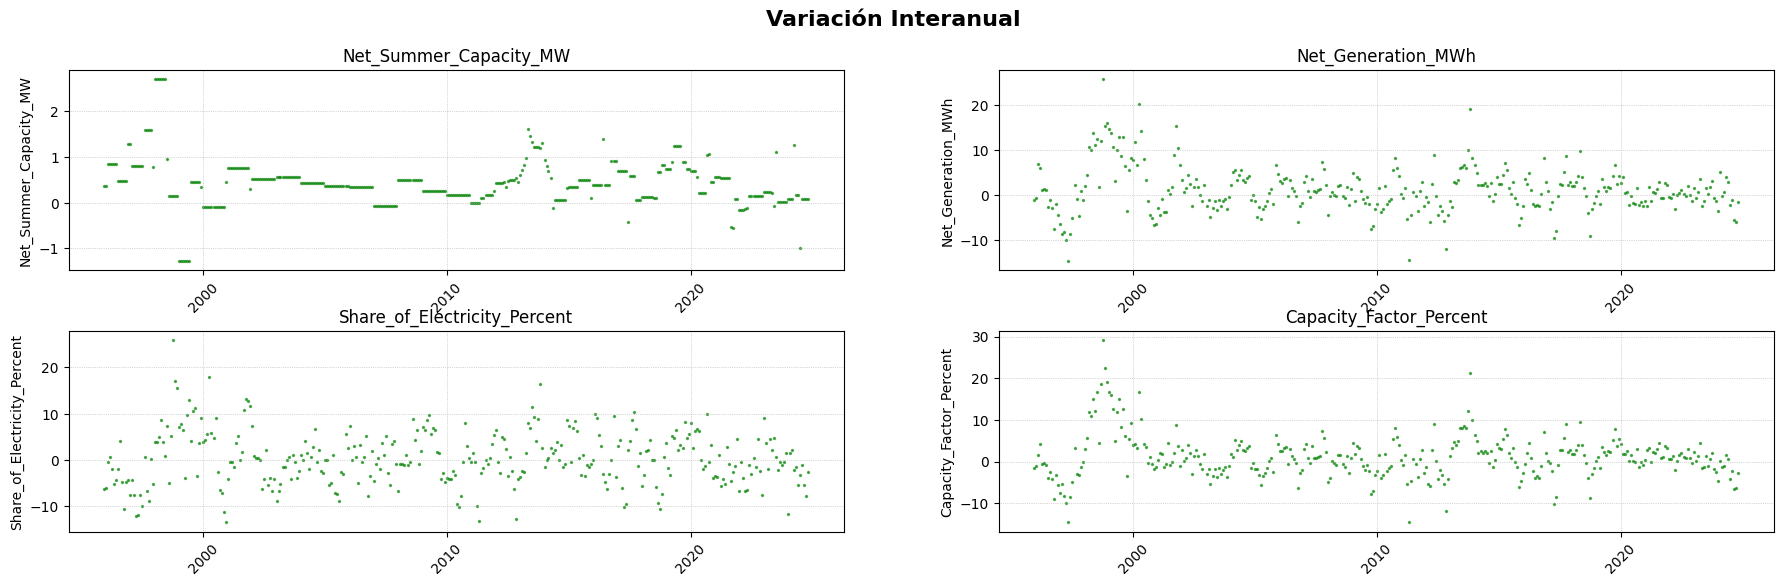

In [ ]:
#Variacion Interanual
monthly_YoY = monthly_data_per_unit.pct_change(periods=12) * 100
print(monthly_YoY.columns)


# Crear figura más grande y con más separación
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 6))
axes = axes.flatten()  # Aplanar los ejes

# Estilo de puntos más limpio
scatter_style = {'color': 'green', 'alpha': 0.6, 's': 2}  # Tamaño de puntos más pequeños

# Graficar cada variable como scatter plot
for i, column in enumerate(monthly_YoY.columns):
    axes[i].scatter(monthly_YoY.index, monthly_YoY[column], **scatter_style)
    axes[i].set_ylabel(column)
    axes[i].grid(True, linestyle=':', linewidth=0.5)  # Cuadrícula más sutil
    axes[i].set_title(f"{column}", fontsize=12)  # Títulos más pequeños

    # Fechas más espaciadas
    axes[i].xaxis.set_major_locator(mdates.YearLocator(10))  # Etiqueta cada 10 años
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)

# Eliminar el último gráfico vacío (posición 5)
#fig.delaxes(axes[len(monthly_YoY.columns)])

# Título global del gráfico
fig.suptitle("Variación Interanual", fontsize=16, fontweight='bold')

# Ajustar espacios entre gráficos
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

In [ ]:
# Sumar todos los valores positivos (años de crecimiento)
crecimiento_total = monthly_YoY[monthly_YoY['Net_Generation_MWh'] > 0]['Net_Generation_MWh'].sum()

# Sumar todos los valores negativos (años de caída)
decrecimiento_total = monthly_YoY[monthly_YoY['Net_Generation_MWh'] < 0]['Net_Generation_MWh'].sum()

# Comparar ambos valores
print(f"Crecimiento total: {crecimiento_total:.2f}%")
print(f"Decrecimiento total: {decrecimiento_total:.2f}%")
print(f"Diferencia neta: {crecimiento_total + decrecimiento_total:.2f}%")


Crecimiento total: 845.77%
Decrecimiento total: -442.05%
Diferencia neta: 403.72%


### Análisis de la Variación interanual

Podemos observar que de manera general, enlos años 90 y 2000 los crecimientos y decrecimientos, se han estabilizado bastante en los últimos años, y aun que la variabilidad no es tan grande, sigue habiendo en computo general un gran crecimiento de todas las variables

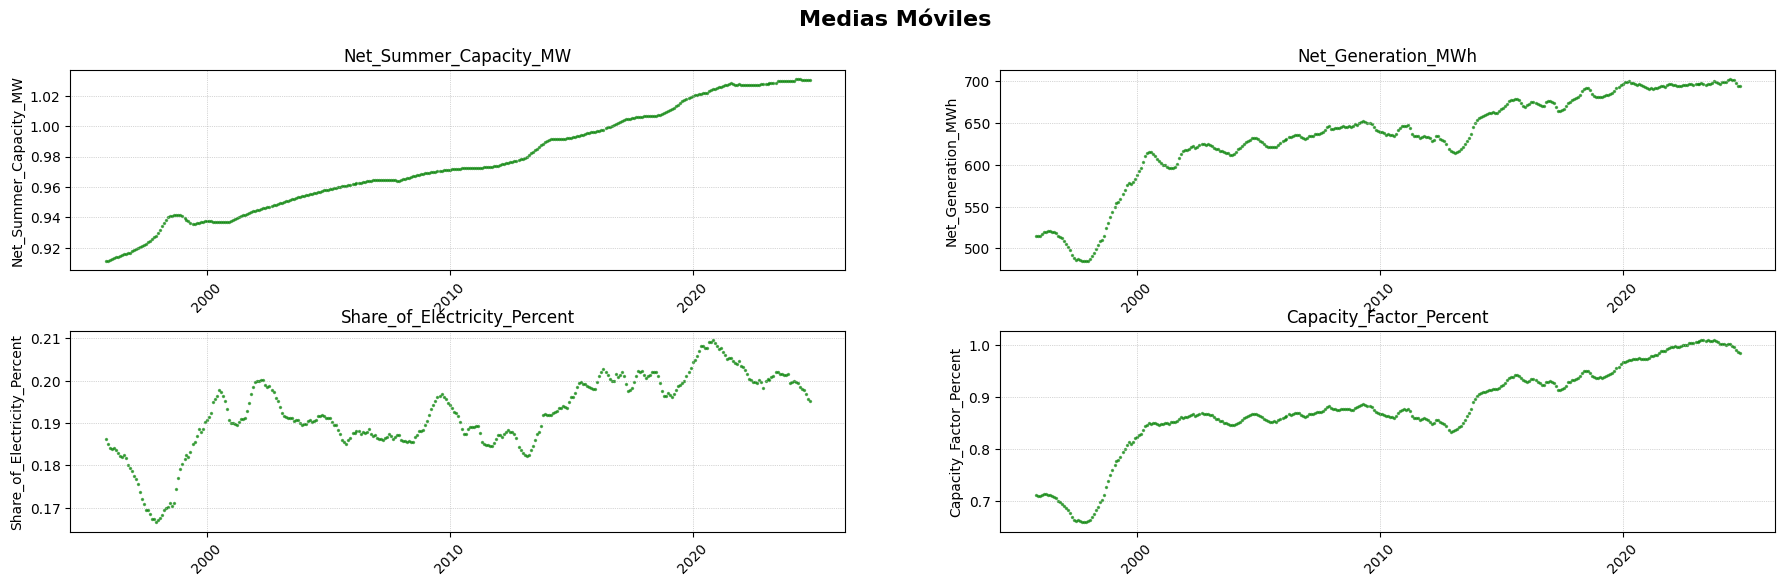

In [ ]:
#Media móvil (12 meses) Suavizar fluctuaciones mensuales
monthly_data_suavizado = monthly_data_per_unit.rolling(window=12).mean()


# Crear figura más grande y con más separación
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 6))
axes = axes.flatten()  # Aplanar los ejes

# Estilo de puntos más limpio
scatter_style = {'color': 'green', 'alpha': 0.6, 's': 2}  # Tamaño de puntos más pequeños

# Graficar cada variable como scatter plot
for i, column in enumerate(monthly_data_suavizado.columns):
    axes[i].scatter(monthly_data_suavizado.index, monthly_data_suavizado[column], **scatter_style)
    axes[i].set_ylabel(column)
    axes[i].grid(True, linestyle=':', linewidth=0.5)  # Cuadrícula más sutil
    axes[i].set_title(f"{column}", fontsize=12)  # Títulos más pequeños

    # Fechas más espaciadas
    axes[i].xaxis.set_major_locator(mdates.YearLocator(10))  # Etiqueta cada 10 años
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)

# Eliminar el último gráfico vacío (posición 5)
#fig.delaxes(axes[len(monthly_data_suavizado.columns)])

# Título global del gráfico
fig.suptitle("Medias Móviles", fontsize=16, fontweight='bold')

# Ajustar espacios entre gráficos
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()


In [ ]:
#monthly_data_suavizado

### Análisis de medias móviles

Si ponemos la media a 1 año, vemos de mejor manera esa tendencia ascendente de las variables, aun que todavia con cierta variabilidad, y con picos de 1995 hasta 2004 y de 2012 a 2017 sin embargo, si la ponemos a 5 años podemos ver esos picos desde el año 2000 al 2004 y de los 2012 al 2017

Como interpretamos esto?

¿Qué nos dice esto sobre la historia de la energía nuclear en EE.UU.?


Los períodos 2000-2004 y 2012-2017 fueron momentos de crecimiento en la eficiencia nuclear.

El crecimiento no fue uniforme → Hubo períodos donde la generación aumentó significativamente y luego se estabilizó.

Eventos específicos pueden explicar estos picos:

2000-2004 → Optimización tecnológica y mejoras operativas en las centrales existentes.

2012-2017 → Modernización de reactores y optimización del ciclo de combustible.

In [ ]:
ejecutar = False  # Cambia a True o False según la condición que desees

if ejecutar:

    monthly_data_diff = monthly_data_per_unit.diff()

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 6))
    axes = axes.flatten()

    scatter_style = {'color': 'green', 'alpha': 0.6, 's': 2}

    for i, column in enumerate(monthly_data_diff.columns):
        axes[i].scatter(monthly_data_diff.index, monthly_data_diff[column], **scatter_style)
        axes[i].set_ylabel(column)
        axes[i].grid(True, linestyle=':', linewidth=0.5)
        axes[i].set_title(f"{column}", fontsize=12)

        axes[i].xaxis.set_major_locator(mdates.YearLocator(10))
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[i].tick_params(axis='x', rotation=45, labelsize=10)

    fig.suptitle("Diferencia Mes a Mes", fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    plt.show()

    crecimiento_total = monthly_data_diff[monthly_data_diff['Net_Generation_MWh'] > 0]['Net_Generation_MWh'].sum()
    decrecimiento_total = monthly_data_diff[monthly_data_diff['Net_Generation_MWh'] < 0]['Net_Generation_MWh'].sum()

    print(f"Crecimiento total: {crecimiento_total:.2f}")
    print(f"Decrecimiento total: {decrecimiento_total:.2f}")
    print(f"Diferencia neta: {crecimiento_total + decrecimiento_total:.2f}")

else:
    print("El código no se ha ejecutado dado que da la misma informacion que la variación interanual.")

El código no se ha ejecutado dado que da la misma informacion que la variación interanual.


In [ ]:
ejecutar_segundo_bloque = False  # Cambia a True o False según la condición que desees

if ejecutar_segundo_bloque:
    monthly_data_log = np.log1p(monthly_data_per_unit)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 6))
    axes = axes.flatten()

    scatter_style = {'color': 'green', 'alpha': 0.6, 's': 2}

    for i, column in enumerate(monthly_data_log.columns):
        axes[i].scatter(monthly_data_log.index, monthly_data_log[column], **scatter_style)
        axes[i].set_ylabel(column)
        axes[i].grid(True, linestyle=':', linewidth=0.5)
        axes[i].set_title(f"{column}", fontsize=12)

        axes[i].xaxis.set_major_locator(mdates.YearLocator(10))
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[i].tick_params(axis='x', rotation=45, labelsize=10)

    fig.suptitle("Escala Logarítmica", fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    plt.show()

    # Aquí podrías realizar cálculos adicionales si es necesario

else:
    print("No se ejecuta por que la escala logartmica al igual que las medias moviles suaviaza pero no aporta información.")


No se ejecuta por que la escala logartmica al igual que las medias moviles suaviaza pero no aporta información.


In [ ]:
from ydata_profiling import ProfileReport

# Generar el reporte de pandas-profiling
profile = ProfileReport(monthly_data_per_unit, title="Reporte de Análisis Exploratorio de Datos", explorative=True)

# Mostrar el reporte
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#Resumen del Análisis de los Datos y sus Transformaciones

En todas las variables y sus distintas transformaciones, podemos notar que hay una tendencia ascendente, con ciertos periodos en los cuales hay un mayor crecimiento (2000-2004 y 2012-2017), a pesar de que la cantidad de reactores activos ha disminuido, aunque no de manera drástica.

Esto nos indica que, a lo largo de los años, la tecnología ha ido mejorando, con posibles grandes avances en campos relacionados con la energía nuclear, como la física nuclear, la física de materiales y la termodinámica, entre otros. Además, las políticas y estrategias de la industria parecen haberse centrado más en modernizar las plantas ya existentes en lugar de construir nuevas.

También es posible que el coste de construir una nueva planta nuclear sea, al menos a corto plazo, mayor que invertir en mejorar las ya existentes, lo que podría explicar esta tendencia (sería interesante investigarlo más a fondo).

El modelo SARIMAX se ajusta bastante bien a los datos, pero creo que una regresion lineal con ML podria "captar" ese patrón de cada x años haber una evolucion tecnologica y por tanto hacer otro "pico" de subida

In [ ]:
!pip install --upgrade skforecast

In [ ]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.15.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.2
Version numpy: 1.26.4


In [ ]:
from sklearn.preprocessing import StandardScaler

#Escalador
scaler = StandardScaler()
X_data=[]
# Seleccionar variables exógenas (sin Net_Generation_MWh)
Var_exogenas = ["Share_of_Electricity_Percent", "Capacity_Factor_Percent", "Net_Summer_Capacity_MW"] #"Net_Summer_Capacity_MW"
X_data = monthly_data_per_unit[Var_exogenas]

# Escalar las variables exógenas
X_escalado = scaler.fit_transform(X_data)

# Convertir de nuevo a DataFrame con los mismos nombres de columnas
X_escalado = pd.DataFrame(X_escalado, columns=Var_exogenas, index=monthly_data_per_unit.index)

# Convertir la fecha en variable numérica (YYYYMM)
X_escalado["Date"] = monthly_data_per_unit.index.year * 100 + monthly_data_per_unit.index.month

# Resetear el índice para evitar problemas
X_escalado.reset_index(drop=True, inplace=True)

# Seleccionar la variable dependiente
Y_data = monthly_data_per_unit["Net_Generation_MWh"].reset_index(drop=True)

X_escalado.head(), Y_data.head()

Y_copy_forecasting = Y_data.copy()
X_copy_forecasting = X_escalado.copy()

# Convertir "Date" en datetime (si aún no lo es)
X_copy_forecasting["Date"] = pd.to_datetime(X_copy_forecasting["Date"], format="%Y%m")

# Crear copias para evitar modificar los datos originales
X_copy_forecasting = X_copy_forecasting.copy()
Y_copy_forecasting = Y_copy_forecasting.copy()

# Asignar "Date" como índice
X_copy_forecasting.set_index("Date", inplace=True)  # Elimina la columna "Date" y la pone como índice
Y_copy_forecasting.index = X_copy_forecasting.index  # Asegurar que tengan el mismo índice


# Verificar la estructura final
#Y_copy_forecasting.head(), Y_copy_forecasting.tail(),X_copy_forecasting.head(), X_copy_forecasting.tail()


In [ ]:
Y_copy_forecasting.head(), X_copy_forecasting.head()

(Date
 1994-12-01    555.018349
 1995-01-01    581.119266
 1995-02-01    475.761468
 1995-03-01    475.963303
 1995-04-01    452.486239
 Name: Net_Generation_MWh, dtype: float64,
             Share_of_Electricity_Percent  Capacity_Factor_Percent  \
 Date                                                                
 1994-12-01                      0.932479                -1.184454   
 1995-01-01                      1.060166                -0.841658   
 1995-02-01                     -0.216701                -1.553620   
 1995-03-01                     -0.663605                -2.212844   
 1995-04-01                     -0.472075                -2.309530   
 
             Net_Summer_Capacity_MW  
 Date                                
 1994-12-01               -1.898114  
 1995-01-01               -1.898114  
 1995-02-01               -1.898114  
 1995-03-01               -1.898114  
 1995-04-01               -1.898114  )

In [ ]:
Y_copy_forecasting = Y_copy_forecasting.asfreq('MS')
Y_copy_forecasting

Date
1994-12-01    555.018349
1995-01-01    581.119266
1995-02-01    475.761468
1995-03-01    475.963303
1995-04-01    452.486239
                 ...    
2024-07-01    743.457447
2024-08-01    742.127660
2024-09-01    666.595745
2024-10-01    621.670213
2024-11-01    658.553191
Freq: MS, Name: Net_Generation_MWh, Length: 360, dtype: float64

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


ModuleNotFoundError: No module named 'skforecast.ForecasterAutoreg'

Método Recursivo -> MAE: 49.35, RMSE: 57.94
Método Directo   -> MAE: 43.44, RMSE: 50.62


<ipython-input-169-9827eca44b31>:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps+1, freq='M')[1:], pred_recursive,


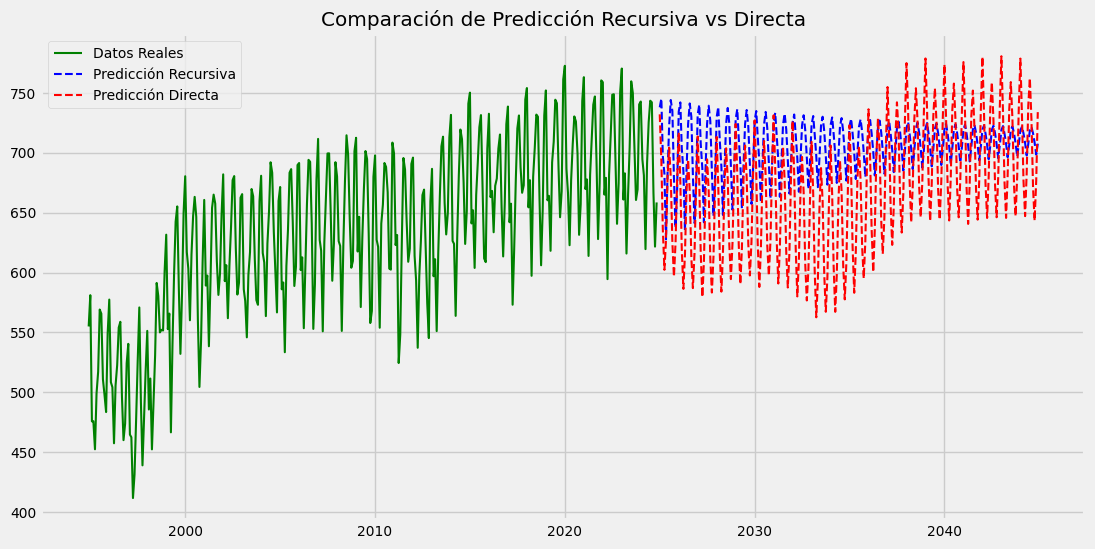

In [ ]:


# 1️⃣ **Preprocesamiento y selección de datos**
# Suponemos que Y_data es una serie temporal con un índice de tiempo
Y_copy_forecasting = Y_copy_forecasting.asfreq('MS')  # Asegurar que la frecuencia sea mensual
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y_copy_forecasting.values.reshape(-1, 1)).flatten()  # Escalar datos

# Convertimos Y_scaled en un DataFrame para facilitar el modelado
Y_data_scaled = pd.Series(Y_scaled, index=Y_data.index)

# 2️⃣ **Definir parámetros de predicción**
años=20
lags = [6,12,24]  # Usaremos los últimos 12 meses para predecir
steps = años*12  # Queremos predecir los próximos años

# 3️⃣ **Definir modelos**
model_ridge = Ridge()

# 4️⃣ **Método Recursivo (Autoregresivo)**
forecaster_recursive = ForecasterRecursive(
    regressor=model_ridge,
    lags=lags
)

# Entrenar modelo recursivo
forecaster_recursive.fit(Y_data_scaled)

# Hacer predicción con método recursivo
pred_recursive = forecaster_recursive.predict(steps=steps)

# 5️⃣ **Método Directo**
forecaster_direct = ForecasterDirect(
    regressor=model_ridge,
    steps=steps,
    lags=lags
)

# Entrenar modelo directo
forecaster_direct.fit(Y_data_scaled)

# Hacer predicción con método directo
pred_direct = forecaster_direct.predict()

# 6️⃣ **Desescalar los resultados**
pred_recursive = scaler.inverse_transform(pred_recursive.values.reshape(-1, 1)).flatten()
pred_direct = scaler.inverse_transform(pred_direct.values.reshape(-1, 1)).flatten()

# 7️⃣ **Evaluación (solo si tenemos datos reales para comparar)**
real_values = Y_copy_forecasting[-steps:]  # Últimos valores reales

mae_recursive = mean_absolute_error(real_values, pred_recursive)
rmse_recursive = np.sqrt(mean_squared_error(real_values, pred_recursive))

mae_direct = mean_absolute_error(real_values, pred_direct)
rmse_direct = np.sqrt(mean_squared_error(real_values, pred_direct))

# Imprimir resultados
print(f"Método Recursivo -> MAE: {mae_recursive:.2f}, RMSE: {rmse_recursive:.2f}")
print(f"Método Directo   -> MAE: {mae_direct:.2f}, RMSE: {rmse_direct:.2f}")

# 8️⃣ **Graficar los resultados**
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(Y_copy_forecasting.index, Y_copy_forecasting, label="Datos Reales", color='green', linestyle="solid")
plt.plot(pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps+1, freq='M')[1:], pred_recursive,
         label="Predicción Recursiva", color='blue', linestyle="dashed")
plt.plot(pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps+1, freq='M')[1:], pred_direct,
         label="Predicción Directa", color='red', linestyle="dashed")
plt.legend()
plt.title("Comparación de Predicción Recursiva vs Directa")
plt.grid(True)
plt.show()


<ipython-input-170-9851c57d2ea1>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_recursive_series = pd.Series(pred_recursive, index=pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps, freq='M'))


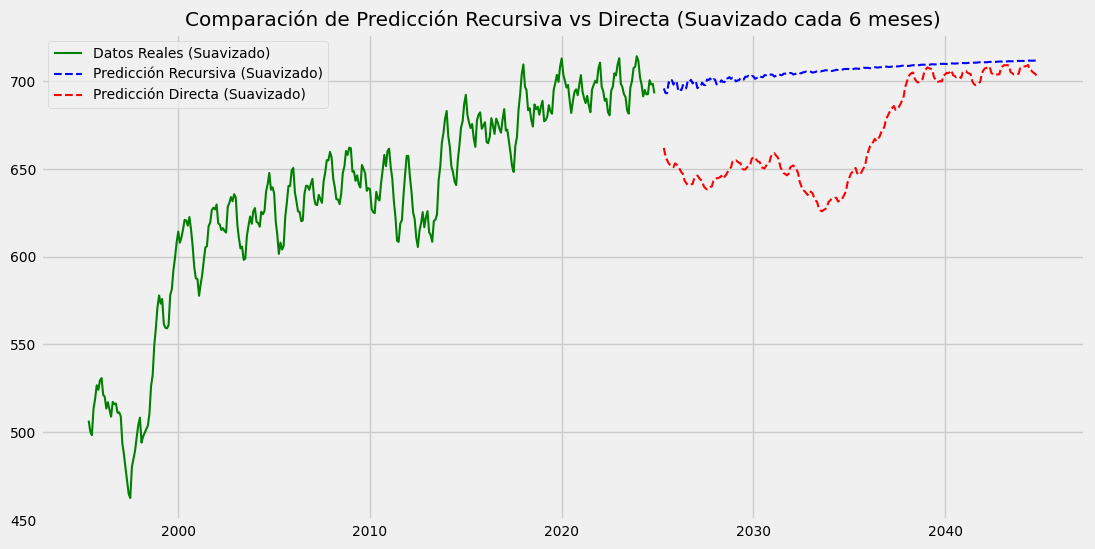

In [ ]:
import matplotlib.pyplot as plt

# Aplicar media móvil de 6 meses a los datos reales
Y_smooth = Y_copy_forecasting.rolling(window=6).mean()

# Aplicar media móvil a las predicciones
pred_recursive_series = pd.Series(pred_recursive, index=pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps, freq='M'))
pred_recursive_smooth = pred_recursive_series.rolling(window=6).mean()

pred_direct_series = pd.Series(pred_direct, index=pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps, freq='M'))
pred_direct_smooth = pred_direct_series.rolling(window=6).mean()

# Graficar
plt.figure(figsize=(12,6))
plt.plot(Y_copy_forecasting.index, Y_smooth, label="Datos Reales (Suavizado)", color='green', linestyle="solid")
plt.plot(pred_recursive_smooth.index, pred_recursive_smooth, label="Predicción Recursiva (Suavizado)", color='blue', linestyle="dashed")
plt.plot(pred_direct_smooth.index, pred_direct_smooth, label="Predicción Directa (Suavizado)", color='red', linestyle="dashed")

plt.legend()
plt.title("Comparación de Predicción Recursiva vs Directa (Suavizado cada 6 meses)")
plt.grid(True)
plt.show()

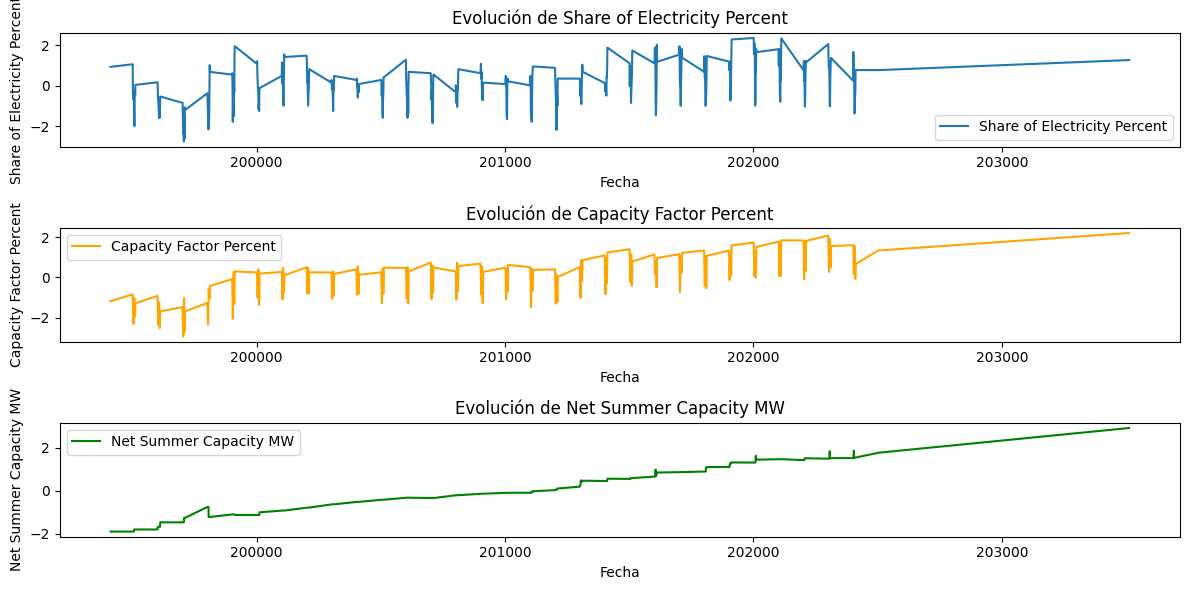

In [ ]:
from sklearn.preprocessing import StandardScaler
monthly_data_suavizado_ml = monthly_data_suavizado.loc['19951201':]
print(monthly_data_suavizado_ml)
# Escalador
scaler = StandardScaler()
X_data = []

# Seleccionar variables exógenas (sin Net_Generation_MWh)
Var_exogenas = ["Share_of_Electricity_Percent", "Capacity_Factor_Percent", "Net_Summer_Capacity_MW"]
X_data = monthly_data_suavizado_ml[Var_exogenas]

# Escalar las variables exógenas
X_escalado_suavizado = scaler.fit_transform(X_data)

# Convertir de nuevo a DataFrame con los mismos nombres de columnas
X_escalado_suavizado = pd.DataFrame(X_escalado_suavizado, columns=Var_exogenas, index=monthly_data_suavizado_ml.index)

# Convertir la fecha en variable numérica (YYYYMM)
X_escalado_suavizado["Date"] = monthly_data_suavizado_ml.index.year * 100 + monthly_data_suavizado_ml.index.month

# Resetear el índice para evitar problemas
X_escalado_suavizado.reset_index(drop=True, inplace=True)

# Seleccionar la variable dependiente
Y_data_suavizado = monthly_data_suavizado_ml["Net_Generation_MWh"].reset_index(drop=True)

# Mostrar las primeras filas para verificar
X_escalado_suavizado.head(), Y_data_suavizado.head()


            Net_Summer_Capacity_MW  Net_Generation_MWh  \
Date                                                     
1995-12-01                0.911298          514.833333   
1996-01-01                0.911579          514.527523   
1996-02-01                0.912223          517.250431   
1996-03-01                0.912867          519.612580   
1996-04-01                0.913511          520.030393   
...                            ...                 ...   
2024-07-01                1.030385          701.947037   
2024-08-01                1.030460          701.296385   
2024-09-01                1.030536          698.100511   
2024-10-01                1.030611          694.856183   
2024-11-01                1.030686          693.948877   

            Share_of_Electricity_Percent  Capacity_Factor_Percent  
Date                                                               
1995-12-01                      0.185092                 0.709709  
1996-01-01                      0.184021 

(   Share_of_Electricity_Percent  Capacity_Factor_Percent  \
 0                     -0.798058                -1.988805   
 1                     -0.918566                -1.996962   
 2                     -0.926156                -1.986309   
 3                     -0.916140                -1.959772   
 4                     -0.949006                -1.963677   
 
    Net_Summer_Capacity_MW    Date  
 0               -1.936288  199512  
 1               -1.927921  199601  
 2               -1.908709  199602  
 3               -1.889498  199603  
 4               -1.870286  199604  ,
 0    514.833333
 1    514.527523
 2    517.250431
 3    519.612580
 4    520.030393
 Name: Net_Generation_MWh, dtype: float64)

RMSE (Suavizado): 9.112784924794948
MAE (Suavizado): 7.50581590619638
Mean (Suavizado): 634.2499910932739
Coeficientes Net Generation (Suavizado): [-3.67968612e-01  5.47747619e+01 -3.23925152e+01  3.92411109e-02] -7253.141353317182


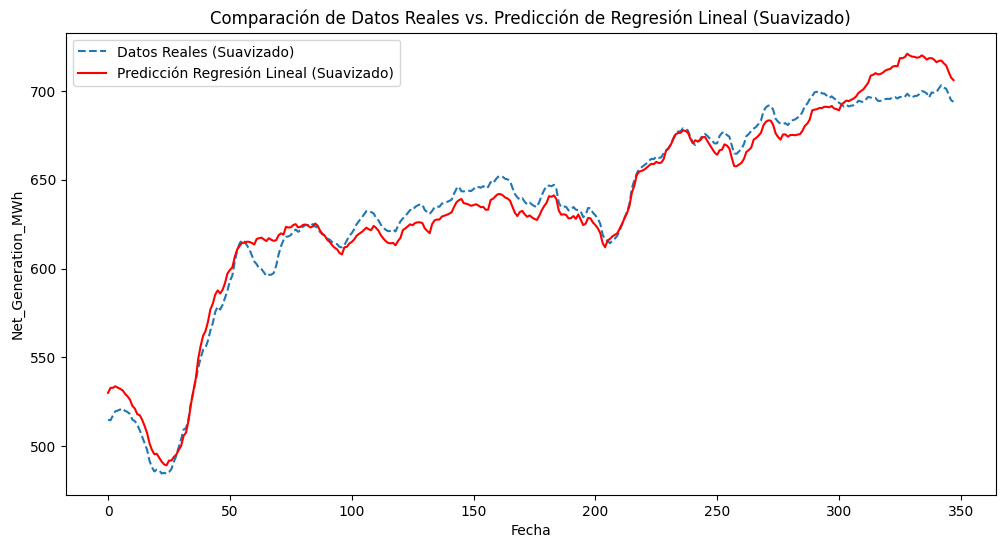

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Crear una instancia del modelo de regresión lineal
model_lr_suavizado = LinearRegression()

# Ajustar el modelo con los datos suavizados
history = model_lr_suavizado.fit(X_escalado_suavizado, Y_data_suavizado)

# Hacer predicciones con el modelo entrenado
Y_pred_suavizado = model_lr_suavizado.predict(X_escalado_suavizado)

# Calcular métricas de evaluación
rmse_suavizado = np.sqrt(mean_squared_error(Y_data_suavizado, Y_pred_suavizado))
print("RMSE (Suavizado):", rmse_suavizado)

mae_suavizado = mean_absolute_error(Y_data_suavizado, Y_pred_suavizado)
print("MAE (Suavizado):", mae_suavizado)

# Promedio de los datos reales suavizados
print("Mean (Suavizado):", Y_data_suavizado.mean())

# Coeficientes del modelo de regresión lineal
print("Coeficientes Net Generation (Suavizado):", model_lr_suavizado.coef_, model_lr_suavizado.intercept_)

# Graficar los resultados
# Graficar los resultados
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(Y_data_suavizado.index, Y_data_suavizado, label="Datos Reales (Suavizado)", linestyle="dashed")
plt.plot(Y_data_suavizado.index, Y_pred_suavizado, label="Predicción Regresión Lineal (Suavizado)", color='red')

# Configurar las etiquetas del eje X para que usen el formato de 'Date' de X_escalado_suavizado
#plt.xticks(X_escalado_suavizado['Date'], labels=X_escalado_suavizado['Date'].astype(str), rotation=45)

plt.legend()
plt.title("Comparación de Datos Reales vs. Predicción de Regresión Lineal (Suavizado)")
plt.xlabel("Fecha")
plt.ylabel("Net_Generation_MWh")

plt.show()

La regresion se realiza bien, para el net generation, pero la proyeccion de net summer capacity, no se ajusta muy bien, por tanto lo suyo seria quitar los datos <1980 para evitar esos outlayers y de esta manera ser mas realista

Con la regresion lineal los valores son:

Evaluación del modelo de Net Generation:

R²: 0.6601

MSE: 3104.6570

MAE: 45.7593


Evaluación del modelo de Net Summer Capacity:

R²: 0.0269

MSE: 4.7402

MAE: 1.5042



Con un polinomio de grado 2 los valores son:

Evaluación del modelo polinómico de Net Generation:

R²: 0.7302

MSE: 2464.9615

MAE: 40.9800


Evaluación del modelo polinómico de Net Summer Capacity:

R²: 0.5449

MSE: 2.2168

MAE: 1.1500



#CALCULAR LAS MEIDAS MOVILES CON SESONAL DESCOMPOSE

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

 Crear una serie temporal con una tendencia y estacionalidad
 Supongamos que 'df' es un DataFrame que ya tenemos con índice de fecha y una columna 'Precio'
result = seasonal_decompose(df['Precio'], model='additive', period=1)

result.plot()
plt.show()


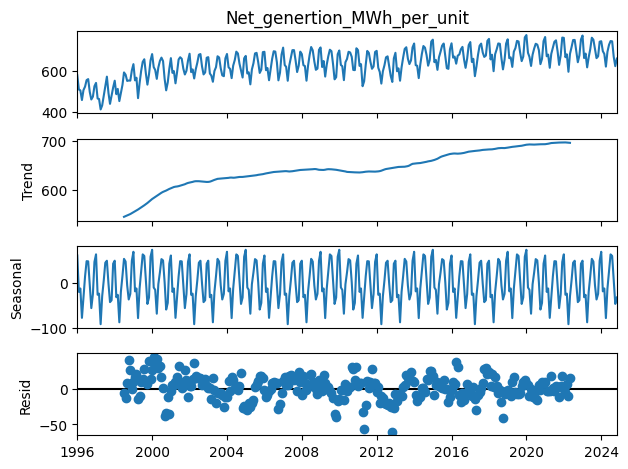

In [ ]:
#Calculo meidas moviles

from statsmodels.tsa.seasonal import seasonal_decompose

#Filtrar los datos para años superiores a 1980
data_media_movil = monthly_data_extracted[monthly_data_extracted.index.year > 1995]['Net_genertion_MWh_per_unit']

result = seasonal_decompose(data_media_movil, model='additive', period=60)

result.plot()
plt.show()


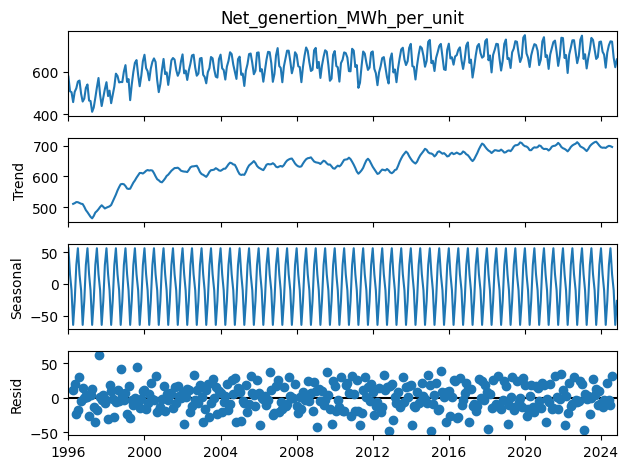

In [ ]:
#Calculo meidas moviles

from statsmodels.tsa.seasonal import seasonal_decompose

#Filtrar los datos para años superiores a 1980
data_media_movil = monthly_data_extracted[monthly_data_extracted.index.year > 1995]['Net_genertion_MWh_per_unit']

result = seasonal_decompose(data_media_movil, model='additive', period=6)

result.plot()
plt.show()

### Coste de implementacion
 de nuevas plantas, mantenimiento de las mismas, gastos de generación, y trata de residuos, idem para 3 fuentes


### Instalacion de plantas nucleares


Vamos a utilizar una base de datos de las plantas nucleares globales, y segun su latitud y longitud ser capaz de hallar otras medidas como la temperatura, quizas las disponibilidad de agua, humedad y demas, para realizar un algortimo de clasificación que dando ciertos datos de una zona, ver si sería un lugar optimo para construir una planta nuclear

In [ ]:
#Cargamos el archivo de las plantas nucleares

# Cargar el archivo Excel
file_path = '/content/power plants database global.xlsx'
excel_data_plants = pd.ExcelFile(file_path)
df_plants = pd.read_excel(excel_data_plants)



In [ ]:
#df_plants

country country_long                                               name  \
0         AFG  Afghanistan       Kajaki Hydroelectric Power Plant Afghanistan   
1         AFG  Afghanistan                                       Kandahar DOG   
2         AFG  Afghanistan                                       Kandahar JOL   
3         AFG  Afghanistan      Mahipar Hydroelectric Power Plant Afghanistan   
4         AFG  Afghanistan   Naghlu Dam Hydroelectric Power Plant Afghanistan   
...       ...          ...                                                ...   
34931     ZMB       Zambia                                              Ndola   
34932     ZMB       Zambia                                              Nkana   
34933     ZMB       Zambia                                     Victoria Falls   
34934     ZWE     Zimbabwe                   Hwange Coal Power Plant Zimbabwe   
34935     ZWE     Zimbabwe  Kariba Dam South Hydroelectric Power Station Z...   

          gppd_idnr  capacity_mw  latitude  longitude primary_fuel  \
0      GEODB0040538          330    323220     651190        Hydro   
1        WKS0070144          100    316700     657950        Solar   
2        WKS0071196          100    316230     657920        Solar   
3      GEODB0040541          660    345560     694787        Hydro   
4      GEODB0040534         1000    346410     697170        Hydro   
...             ...          ...       ...        ...          ...   
34931    WRI1022386          500   -129667     286333          Oil   
34932    WRI1022384          200   -128167     282000          Oil   
34933    WRI1022380         1080   -179167     258500        Hydro   
34934  GEODB0040404         9200   -183835     264700         Coal   
34935  GEODB0003803         7500   -165222     287619        Hydro   

      other_fuel1 other_fuel2  ... estimated_generation_gwh_2013  \
0             NaN         NaN  ...                       12377.0   
1             NaN         NaN  ...                        1843.0   
2             NaN         NaN  ...                        1864.0   
3             NaN         NaN  ...                       22506.0   
4             NaN         NaN  ...                       40616.0   
...           ...         ...  ...                           ...   
34931         NaN         NaN  ...                           NaN   
34932         NaN         NaN  ...                           NaN   
34933         NaN         NaN  ...                       57578.0   
34934         NaN         NaN  ...                           NaN   
34935         NaN         NaN  ...                      399975.0   

       estimated_generation_gwh_2014 estimated_generation_gwh_2015  \
0                            16290.0                        9739.0   
1                             1748.0                        1825.0   
2                             1758.0                        1910.0   
3                            20355.0                       14690.0   
4                            35722.0                       27099.0   
...                              ...                           ...   
34931                            NaN                           NaN   
34932                            NaN                           NaN   
34933                        57578.0                       54894.0   
34934                            NaN                           NaN   
34935                       399975.0                      374502.0   

      estimated_generation_gwh_2016 estimated_generation_gwh_2017  \
0                           13776.0                       11950.0   
1                            1770.0                        1829.0   
2                            1762.0                        1872.0   
3                           23018.0                       17491.0   
4                           39538.0                       35080.0   
...                             ...                           ...   
34931                           NaN                

In [ ]:
#Vamos a fitrar las que sean de primario nuclear
df_plants_nuclear = df_plants[df_plants['primary_fuel'] == 'Nuclear']
#df_plants_nuclear

country              country_long                           name  \
101       ARG                 Argentina                       ATUCHA I   
102       ARG                 Argentina                      ATUCHA II   
229       ARG                 Argentina                        EMBALSE   
328       ARM                   Armenia                     Armenian-2   
1043      BEL                   Belgium                         DOEL 4   
...       ...                       ...                            ...   
33710     USA  United States of America                     V C Summer   
33850     USA  United States of America                         Vogtle   
34035     USA  United States of America                    Waterford 3   
34055     USA  United States of America        Watts Bar Nuclear Plant   
34409     USA  United States of America  Wolf Creek Generating Station   

        gppd_idnr  capacity_mw  latitude  longitude primary_fuel other_fuel1  \
101    ARG0000029         3700   -339670    -592059      Nuclear         NaN   
102    ARG0000030         7450   -339674    -592045      Nuclear         NaN   
229    ARG0000112         6480   -322316    -644422      Nuclear         NaN   
328    WRI1019028         3750    401805     441498      Nuclear         NaN   
1043   WRI1002223        29100    513254      42597      Nuclear         NaN   
...           ...          ...       ...        ...          ...         ...   
33710  USA0006127        10296    342983    -813153      Nuclear         NaN   
33850  USA0000649        24300    331427    -817625      Nuclear         NaN   
34035  USA0004270        11998    299953    -904716      Nuclear         NaN   
34055  USA0007722        25398    356021    -847895      Nuclear         NaN   
34409  USA0000210        12677    382393    -956898      Nuclear         NaN   

      other_fuel2  ... estimated_generation_gwh_2013  \
101           NaN  ...                           NaN   
102           NaN  ...                           NaN   
229           NaN  ...                           NaN   
328           NaN  ...                           NaN   
1043          NaN  ...                           NaN   
...           ...  ...                           ...   
33710         NaN  ...                           NaN   
33850         NaN  ...                           NaN   
34035         NaN  ...                           NaN   
34055         NaN  ...                           NaN   
34409         NaN  ...                           NaN   

       estimated_generation_gwh_2014 estimated_generation_gwh_2015  \
101                              NaN                           NaN   
102                              NaN                           NaN   
229                              NaN                           NaN   
328                              NaN                           NaN   
1043                             NaN                           NaN   
...                              ...                           ...   
33710                            NaN                           NaN   
33850                            NaN                           NaN   
34035                            NaN                           NaN   
34055                            NaN                           NaN   
34409                            NaN                           NaN   

      estimated_generation_gwh_2016 estimated_generation_gwh_2017  \
101                             NaN                      130391.0   
102                             NaN                      262545.0   
229                             NaN                      228362.0   
328                             NaN                      241104.0   
1043                            NaN                     2020397.0   
...                             ...                           ...   
33710                           NaN                      816811.0   
33850                           NaN                     1927788.0   
34035                

In [ ]:
# Filtramos las columnas necesarias
df_plants_nuclear_filter = df_plants_nuclear[['country', 'latitude', 'longitude', 'capacity_mw']].copy()

# Convertir latitud y longitud a formato correcto (dividir entre 10,000 si están en formato entero)
df_plants_nuclear_filter['latitude'] = (df_plants_nuclear_filter['latitude'] / 1e4).round(4)
df_plants_nuclear_filter['longitude'] = (df_plants_nuclear_filter['longitude'] / 1e4).round(4)

# Generar lista de coordenadas en formato "latitud,longitud"
coordenadas = df_plants_nuclear_filter.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1).tolist()

# Filtramos las columnas necesarias
df_plants_nuclear_filter = df_plants_nuclear[['country', 'latitude', 'longitude', 'capacity_mw']].copy()

# Convertir latitud y longitud a formato correcto (dividir entre 10,000 si están en formato entero)
df_plants_nuclear_filter['latitude'] = (df_plants_nuclear_filter['latitude'] / 1e4).round(4)
df_plants_nuclear_filter['longitude'] = (df_plants_nuclear_filter['longitude'] / 1e4).round(4)



-33.967,-59.2059
-33.9674,-59.2045
-32.2316,-64.4422
40.1805,44.1498
51.3254,4.2597
50.5342,5.2751
50.5342,5.2751
-23.0087,-44.4574
-23.0072,-44.4588
43.7438,23.7723
44.3391,-81.5747
44.319,-81.6027
43.8697,-78.7239
43.8107,-79.0689
43.8096,-79.0639
45.0686,-66.4543
39.74,116.03
19.46,108.9
22.6,114.54
21.67,108.56
30.44,120.94
25.4426,119.444
39.8,121.48
22.6,114.55
27.0446,120.2855
30.433,120.9501
34.69,119.46
21.71,112.26
49.0852,16.1479
49.1796,14.3795
60.3708,26.3468
61.2371,21.4433
47.5103,2.875
45.256,-0.6932
45.7973,5.2706
49.416,6.2169
47.2254,0.1656
50.09,4.7894
46.4563,0.6548
44.6325,4.7546
47.7321,2.5185
47.9032,7.5631
49.5366,-1.8823
44.106,0.8443
51.0141,2.1332
48.5171,3.5181
49.8582,0.6354
49.9764,1.2107
45.4043,4.7554
47.7197,1.5783
44.3311,4.7311
53.8506,9.345
52.4716,7.3204
52.0356,9.4135
48.6049,12.2936
48.515,10.4016
49.0408,9.1759
49.2529,8.4364
46.5739,18.8536
24.8747,75.6189
14.865,74.4385
21.2384,73.3489
8.1691,77.1327
8.1689,77.7126
12.5571,80.1754
28.156,78.40

'-33.967,-59.2059\n-33.9674,-59.2045\n-32.2316,-64.4422\n40.1805,44.1498\n51.3254,4.2597\n50.5342,5.2751\n50.5342,5.2751\n-23.0087,-44.4574\n-23.0072,-44.4588\n43.7438,23.7723\n44.3391,-81.5747\n44.319,-81.6027\n43.8697,-78.7239\n43.8107,-79.0689\n43.8096,-79.0639\n45.0686,-66.4543\n39.74,116.03\n19.46,108.9\n22.6,114.54\n21.67,108.56\n30.44,120.94\n25.4426,119.444\n39.8,121.48\n22.6,114.55\n27.0446,120.2855\n30.433,120.9501\n34.69,119.46\n21.71,112.26\n49.0852,16.1479\n49.1796,14.3795\n60.3708,26.3468\n61.2371,21.4433\n47.5103,2.875\n45.256,-0.6932\n45.7973,5.2706\n49.416,6.2169\n47.2254,0.1656\n50.09,4.7894\n46.4563,0.6548\n44.6325,4.7546\n47.7321,2.5185\n47.9032,7.5631\n49.5366,-1.8823\n44.106,0.8443\n51.0141,2.1332\n48.5171,3.5181\n49.8582,0.6354\n49.9764,1.2107\n45.4043,4.7554\n47.7197,1.5783\n44.3311,4.7311\n53.8506,9.345\n52.4716,7.3204\n52.0356,9.4135\n48.6049,12.2936\n48.515,10.4016\n49.0408,9.1759\n49.2529,8.4364\n46.5739,18.8536\n24.8747,75.6189\n14.865,74.4385\n21.2384,73.3

🔍 Coordenadas en el formato correcto para Open-Meteo:
-33.967,-59.2059
-33.9674,-59.2045
-32.2316,-64.4422
40.1805,44.1498
51.3254,4.2597
50.5342,5.2751
50.5342,5.2751
-23.0087,-44.4574
-23.0072,-44.4588
43.7438,23.7723
44.3391,-81.5747
44.319,-81.6027
4


🔍 Primeras coordenadas formateadas para la API:
Latitudes:  [-33.967, -33.9674, -32.2316, 40.1805, 51.3254]
Longitudes: [-59.2059, -59.2045, -64.4422, 44.1498, 4.2597]


La propia pagina de open-meteo tiene el codigo de python para hacer las consultas, simplemente la modificamos para que lo haga por lotes de 5 en 5, que es loq ue permite la pagina, pero debido al limite de consultas diarias, en vez de coger datos historicos de los ultmos años, vamos a coger un dia de verano y otro de invierno, y asi hallar la media, aun que no es lo mas optimo, a nivel de procedimiento sería el mismo, lo unico que tendriamos que extraer mas datos, pero la idea que es sacar datos climatologicos y realizar un modelo predictivo de zonas que son aptas para nuevas plantas nucleares sigue siendo válido

In [ ]:
import os
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time

# Ruta del archivo donde se guardarán los datos meteorológicos
archivo_datos = "df_media.xlsx"

# Si el archivo ya existe, cargar los datos y evitar la consulta a la API
if os.path.exists(archivo_datos):
    print(f"El archivo {archivo_datos} ya existe. No se ejecuta la API.")
    df_clima = pd.read_excel(archivo_datos)

    # Asegurar que las coordenadas tienen el formato correcto
    df_clima["latitude"] = df_clima["latitude"].round(4)
    df_clima["longitude"] = df_clima["longitude"].round(4)

else:
    print("Ejecutando la API y guardando los datos...")

    # Configurar caché y reintentos
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Extraer listas de latitudes y longitudes **con redondeo previo** para evitar errores de precisión
    df_plants_nuclear_filter["latitude"] = df_plants_nuclear_filter["latitude"].round(4)
    df_plants_nuclear_filter["longitude"] = df_plants_nuclear_filter["longitude"].round(4)

    latitudes = df_plants_nuclear_filter["latitude"].tolist()
    longitudes = df_plants_nuclear_filter["longitude"].tolist()

    # Definir los días de consulta (uno de verano y uno de invierno)
    dias_representativos = ["2024-07-15", "2024-01-15"]

    # Lista para almacenar los resultados
    datos_completos = []

    # Procesar coordenadas en lotes de 5
    for i in range(0, len(latitudes), 5):
        lat_lote = latitudes[i:i + 5]
        lon_lote = longitudes[i:i + 5]

        print(f"\n🔍 Consultando datos para {len(lat_lote)} ubicaciones...")

        for dia in dias_representativos:
            print(f"📅 Día seleccionado: {dia}")

            # Parámetros de la API con lotes de coordenadas
            params = {
                "start_date": dia,
                "end_date": dia,
                "daily": ["temperature_2m_max", "temperature_2m_min", "relative_humidity_2m_mean", "precipitation_sum"],
                "timezone": "auto",
                "latitude": lat_lote,
                "longitude": lon_lote
            }

            # Intentar hacer la consulta con control de errores
            try:
                responses = openmeteo.weather_api(url, params=params)
            except Exception as e:
                print(f"❌ Error en la consulta a la API: {e}")
                time.sleep(5)  # Esperar antes de la próxima solicitud
                continue  # Saltar a la siguiente iteración

            # Procesar cada respuesta por ubicación
            for idx, response in enumerate(responses):
                print(f"✅ Procesando datos para {lat_lote[idx]}, {lon_lote[idx]} en {dia}")

                # Verificar si hay datos en la respuesta
                if not response.Daily():
                    print(f"⚠️ No hay datos disponibles para {lat_lote[idx]}, {lon_lote[idx]}.")
                    continue

                # Extraer datos diarios
                daily = response.Daily()
                temp_max = daily.Variables(0).ValuesAsNumpy()
                temp_min = daily.Variables(1).ValuesAsNumpy()
                humedad_media = daily.Variables(2).ValuesAsNumpy()
                precipitacion_total = daily.Variables(3).ValuesAsNumpy()

                # **Usar las coordenadas originales en lugar de las devueltas por la API**
                daily_data = {
                    "date": [dia],
                    "latitude": [lat_lote[idx]],  # Usa el valor original
                    "longitude": [lon_lote[idx]],  # Usa el valor original
                    "temperature_max": temp_max,
                    "temperature_min": temp_min,
                    "humidity_mean": humedad_media,
                    "precipitation_sum": precipitacion_total
                }

                df_lote = pd.DataFrame(data=daily_data)
                datos_completos.append(df_lote)

            # **Esperar 3 segundos** para evitar bloqueos de la API
            time.sleep(3)

    # Verificar si hay datos antes de concatenar y guardar en un archivo
    if datos_completos:
        df_clima = pd.concat(datos_completos, ignore_index=True)
        df_clima.to_excel(archivo_datos, index=False)
        print(f"Datos guardados en {archivo_datos}.")

    else:
        print("⚠️ No se han obtenido datos de la API.")

# Ahora `df_clima` contiene los datos y las coordenadas originales para hacer el merge



Ejecutando la API y guardando los datos...

🔍 Consultando datos para 5 ubicaciones...
📅 Día seleccionado: 2024-07-15
✅ Procesando datos para -33.967, -59.2059 en 2024-07-15
✅ Procesando datos para -33.9674, -59.2045 en 2024-07-15
✅ Procesando datos para -32.2316, -64.4422 en 2024-07-15
✅ Procesando datos para 40.1805, 44.1498 en 2024-07-15
✅ Procesando datos para 51.3254, 4.2597 en 2024-07-15
📅 Día seleccionado: 2024-01-15
✅ Procesando datos para -33.967, -59.2059 en 2024-01-15
✅ Procesando datos para -33.9674, -59.2045 en 2024-01-15
✅ Procesando datos para -32.2316, -64.4422 en 2024-01-15
✅ Procesando datos para 40.1805, 44.1498 en 2024-01-15
✅ Procesando datos para 51.3254, 4.2597 en 2024-01-15

🔍 Consultando datos para 5 ubicaciones...
📅 Día seleccionado: 2024-07-15
✅ Procesando datos para 50.5342, 5.2751 en 2024-07-15
✅ Procesando datos para 50.5342, 5.2751 en 2024-07-15
✅ Procesando datos para -23.0087, -44.4574 en 2024-07-15
✅ Procesando datos para -23.0072, -44.4588 en 2024-07-1

In [ ]:
# Calcular las medias entre verano e invierno
df_media = df_clima.groupby(["latitude", "longitude"]).agg({
    "temperature_max": "mean",
    "temperature_min": "mean",
    "humidity_mean": "mean",
    "precipitation_sum": "mean"
}).reset_index()
print(df_media)

     latitude  longitude  temperature_max  temperature_min  humidity_mean  \
0    -33.9674   -59.2045        23.859001         9.634000      65.032135   
1    -33.9670   -59.2059        23.852501         9.627500      65.030853   
2    -33.6737    18.4281        20.577999        12.403000      74.962234   
3    -32.2316   -64.4422        20.749001         8.249001      66.491432   
4    -23.0087   -44.4574        26.006001        21.080999      90.104485   
..        ...        ...              ...              ...            ...   
187   60.3708    26.3468         6.805500         3.055500      87.108849   
188   60.4028    18.1744         8.462000         4.062000      73.239136   
189   61.2371    21.4433         5.579000        -0.046000      79.948341   
190   67.4667    32.4667         2.897000        -2.628000      75.524643   
191   68.0503   166.5389        -8.864500       -17.939501      81.843430   

     precipitation_sum  
0                 0.00  
1                 0.00  


In [ ]:
#Guardamos el df de los datos extraidos por la api, para no tener que extraerlos cada vez
#df_media.to_excel('df_media.xlsx', index=False)

In [ ]:
df_plants_nuclear_filter

country  latitude  longitude  capacity_mw
101       ARG  -33.9670   -59.2059         3700
102       ARG  -33.9674   -59.2045         7450
229       ARG  -32.2316   -64.4422         6480
328       ARM   40.1805    44.1498         3750
1043      BEL   51.3254     4.2597        29100
...       ...       ...        ...          ...
33710     USA   34.2983   -81.3153        10296
33850     USA   33.1427   -81.7625        24300
34035     USA   29.9953   -90.4716        11998
34055     USA   35.6021   -84.7895        25398
34409     USA   38.2393   -95.6898        12677

[195 rows x 4 columns]

In [ ]:
#Mergeamos los datos para crear el df con todas las variables
df_final_nuclear = df_plants_nuclear_filter.merge(df_media, on=['latitude', 'longitude'], how='left')
df_final_nuclear

country  latitude  longitude  capacity_mw  temperature_max  \
0       ARG  -33.9670   -59.2059         3700        23.852501   
1       ARG  -33.9674   -59.2045         7450        23.859001   
2       ARG  -32.2316   -64.4422         6480        20.749001   
3       ARM   40.1805    44.1498         3750        19.465500   
4       BEL   51.3254     4.2597        29100        13.884001   
..      ...       ...        ...          ...              ...   
190     USA   34.2983   -81.3153        10296        25.798500   
191     USA   33.1427   -81.7625        24300        26.637001   
192     USA   29.9953   -90.4716        11998        25.005499   
193     USA   35.6021   -84.7895        25398        18.122499   
194     USA   38.2393   -95.6898        12677        10.736000   

     temperature_min  humidity_mean  precipitation_sum  
0           9.627500      65.030853               0.00  
1           9.634000      65.032135               0.00  
2           8.249001      66.491432               0.00  
3           7.765500      50.107079               0.70  
4           6.509000      78.819778               6.80  
..               ...            ...                ...  
190        15.398500      62.633087               1.00  
191        14.912001      61.963295               0.90  
192        14.205500      83.050079               1.25  
193        11.047500      76.631157              10.05  
194         3.061000      60.627396               0.70  

[195 rows x 8 columns]

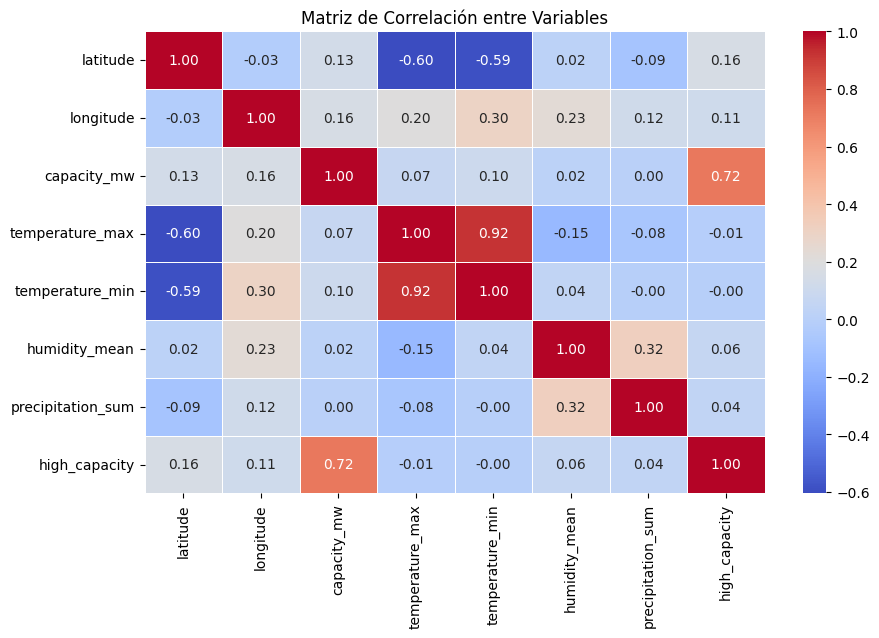

In [ ]:
#Importamos librerias de plots
from matplotlib import pyplot as plt
from seaborn import heatmap
import matplotlib.dates as mdates

#Ploteamos la matriz de correlacion para ver como se relacionan las variables
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas relevantes para la correlación
df_corr = df_final_nuclear.drop(columns=["country"])  # Eliminamos la categórica "country"

# Crear un heatmap de correlación
plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()


Lo que sabemos:

🔹 Las plantas nucleares son más eficientes en climas fríos porque los reactores generan grandes cantidades de calor, y enfriar el sistema es más fácil en lugares fríos.

🔹 En zonas cálidas, el enfriamiento es menos eficiente y los costes de operación pueden aumentar.


🔹 La mayoría de las plantas nucleares están cerca de cuerpos de agua (mares, ríos o lagos) para usar grandes cantidades de agua de refrigeración.

🔹 Zonas con mayor humedad suelen estar cerca de grandes fuentes de agua, por lo que es lógico que las plantas nucleares de alta capacidad se ubiquen allí.

🔹 Muchos países con una alta dependencia de la energía nuclear (Francia, Canadá, Rusia, Finlandia, Suecia, EE.UU. norte, China noreste) tienen sus plantas en zonas más frías y húmedas.

🔹 En contraste, en regiones muy cálidas (cercanas al ecuador), las plantas nucleares son menos comunes debido a los problemas de refrigeración y el alto costo de operación en climas cálidos.


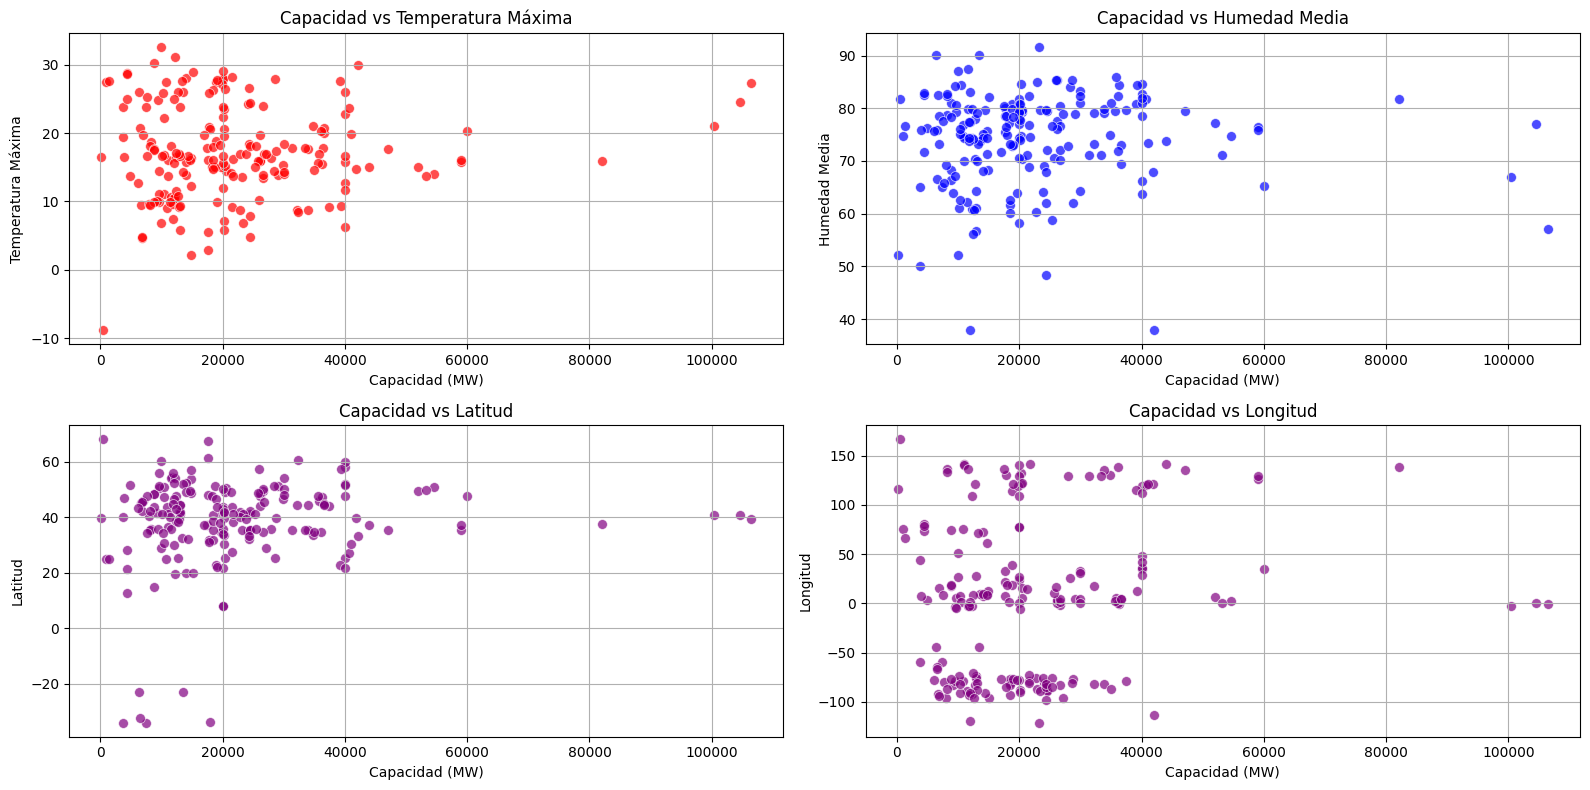

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la figura con 2 gráficos por fila
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Scatter plot 1: Capacity vs Temperature Max
sns.scatterplot(
    ax=axes[0, 0],
    x=df_clustering["capacity_mw"],
    y=df_clustering["temperature_max"],
    color="red",
    alpha=0.7,
    s=50
)
axes[0, 0].set_xlabel("Capacidad (MW)")
axes[0, 0].set_ylabel("Temperatura Máxima")
axes[0, 0].set_title("Capacidad vs Temperatura Máxima")
axes[0, 0].grid(True)

# Scatter plot 2: Capacity vs Humidity Mean
sns.scatterplot(
    ax=axes[0, 1],
    x=df_clustering["capacity_mw"],
    y=df_clustering["humidity_mean"],
    color="blue",
    alpha=0.7,
    s=50
)
axes[0, 1].set_xlabel("Capacidad (MW)")
axes[0, 1].set_ylabel("Humedad Media")
axes[0, 1].set_title("Capacidad vs Humedad Media")
axes[0, 1].grid(True)

# Scatter plot 3: Capacity vs Latitude
sns.scatterplot(
    ax=axes[1, 0],
    x=df_clustering["capacity_mw"],
    y=df_final_nuclear["latitude"].dropna(),
    color="purple",
    alpha=0.7,
    s=50
)
axes[1, 0].set_xlabel("Capacidad (MW)")
axes[1, 0].set_ylabel("Latitud")
axes[1, 0].set_title("Capacidad vs Latitud")
axes[1, 0].grid(True)

# Scatter plot 4: Capacity vs Longitude
sns.scatterplot(
    ax=axes[1, 1],
    x=df_clustering["capacity_mw"],
    y=df_final_nuclear["longitude"].dropna(),
    color="purple",
    alpha=0.7,
    s=50
)
axes[1, 1].set_xlabel("Capacidad (MW)")
axes[1, 1].set_ylabel("Longitud")
axes[1, 1].set_title("Capacidad vs Longitud")
axes[1, 1].grid(True)

# Ajustar espacio entre gráficos
plt.tight_layout()
plt.show()



Aun que noparce haber una relacion lineal, entre las variables y la capacidad, si queparece haber unas zonas optimas para la construcccion de las plantas nucelares

En base a eso, crearemos un algoritmo de clasificacion, que en funcion de  las variables diga si es buena zona o no

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# Definir high_capacity como 1 si capacity_mw >= quantile de lo contrario 0
threshold = df_final_nuclear["capacity_mw"].quantile(0.70)
df_final_nuclear["high_capacity"] = (df_final_nuclear["capacity_mw"] >= threshold).astype(int)

# Seleccionar variables predictoras (X) y variable objetivo (y)
X = df_final_nuclear[["temperature_max", "temperature_min", "humidity_mean", "precipitation_sum",
"latitude", "longitude"]]
y = df_final_nuclear["high_capacity"]

# Dividir en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo Random Forest
modelo_clasificador = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_clasificador.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = modelo_clasificador.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"""
📊 **Evaluación del Modelo**
----------------------------------
✅ **Precisión (Accuracy):** {accuracy:.4f}

📋 **Reporte de Clasificación:**
{report}

🔢 **Matriz de Confusión:**
{conf_matrix}
""")


📊 **Evaluación del Modelo**
----------------------------------
✅ **Precisión (Accuracy):** 0.7436

📋 **Reporte de Clasificación:**
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        29
           1       0.50      0.20      0.29        10

    accuracy                           0.74        39
   macro avg       0.64      0.57      0.56        39
weighted avg       0.70      0.74      0.70        39


🔢 **Matriz de Confusión:**
[[27  2]
 [ 8  2]]



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definir función para evaluar diferentes thresholds
def evaluar_threshold(df, thresholds):
    resultados = []

    for threshold in thresholds:
        # Definir high_capacity según el umbral
        df["high_capacity"] = (df["capacity_mw"] >= df["capacity_mw"].quantile(threshold)).astype(int)

        # Seleccionar variables predictoras y objetivo
        X = df[["temperature_max", "temperature_min", "humidity_mean", "precipitation_sum", "latitude", "longitude"]]
        y = df["high_capacity"]

        # Dividir en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Entrenar modelo Random Forest
        modelo_clasificador = RandomForestClassifier(n_estimators=100, random_state=42)
        modelo_clasificador.fit(X_train, y_train)

        # Predicciones y evaluación
        y_pred = modelo_clasificador.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Guardar resultados
        resultados.append({
            "Threshold": threshold,
            "Accuracy": accuracy,
            "Recall High Capacity": report["1"]["recall"],
            "F1-score High Capacity": report["1"]["f1-score"],
            "Confusion Matrix": conf_matrix
        })

    return pd.DataFrame(resultados)

# Lista de thresholds a evaluar
thresholds = [0.60, 0.65, 0.70, 0.75,0.8,0.9]

# Ejecutar la evaluación
df_resultados = evaluar_threshold(df_final_nuclear, thresholds)
display(df_resultados)  # Para mostrar la tabla con resultados



Threshold  Accuracy  Recall High Capacity  F1-score High Capacity  \
0       0.60  0.641026              0.384615                0.416667   
1       0.65  0.615385              0.083333                0.117647   
2       0.70  0.743590              0.200000                0.285714   
3       0.75  0.743590              0.111111                0.166667   
4       0.80  0.794872              0.250000                0.333333   
5       0.90  0.871795              0.166667                0.285714   

     Confusion Matrix  
0   [[20, 6], [8, 5]]  
1  [[23, 4], [11, 1]]  
2   [[27, 2], [8, 2]]  
3   [[28, 2], [8, 1]]  
4   [[29, 2], [6, 2]]  
5   [[33, 0], [5, 1]]

Tenemos el siguiente problema, por random forest, a mayor treshold mas precision tiene, pero peor detecta las high capacity, simplemente por que hay muchas mas low capacity, por tanto es mas "fácil" acertar

Dos posibles enfoques:

Como los datos estan sesgados, ya que todos son datos que contienen plantas nucleares, podriamos coger por ejemplo el 30% de las de menor capacidad, y definirlas como ni viable, e introducir a mano localizaciones que sabemos que no son optimas, como el sahara con alta temperatura y baja humedad, y de esta manera el modelo entrenaria sobre datos menos sesgados quizá mejoraría

La otra sería crear un algoritmo de clustering, que encuentre aquellas condiciones de temperatura humedad etc, en las cuales las plantas son mas eficientes, y luego aplicar esas condiciones a futuras localizaciones para ver si son viables o no
